# Исследование успешности стартапов

**Цель исследования** - Изучить данные о стартапах, выгруженные `2018-01-01`.

**Задача** - разработать модель для предсказания успешности стартапа (закроется или нет).

**План исследования:**

1. Изучить данные;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Корреляционный анализ;
5. Обучение модели;
6. Анализ важности признаков;
7. Общий вывод.

**Согласно документации к данным:**

Файл `kaggle_startups_train.csv` - содержит информацию о стартапах, которые будут использоваться в качестве обучающих данных.

Файл `kaggle_startups_test.csv` - содержит информацию стартапах, которые будут использоваться в качестве тестовых данных. 

**Описание полей данных:**

- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий)
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

# Изучение данных.
## Импорт библиотек

In [1]:
import os
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro

# Загружаем классы для работы с пайплайнами
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Импортируем классы для машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

# Импортируем метрику для оценки качества модели
from sklearn.metrics import f1_score

# Импортируем сторонние библиотеки
import shap
import phik
from phik.report import plot_correlation_matrix

from Levenshtein import distance

from optuna.integration import OptunaSearchCV 
from optuna import distributions
from optuna.exceptions import ExperimentalWarning

import missingno as msno

In [2]:
# Для игнорирования предупреждений
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", ExperimentalWarning)

## Функции

In [3]:
def index_na(df):
    '''
    Функция принимает датафрейм и 
    находит индексы строк, в которых есть
    пропущенные значения во всех столбцах
    отвечащющие за расположение и возвращает их.

    '''

    index = (
        df[(df['region'].isna() == 1)
           & (df['city'].isna() == 1)
           & (df['country_code'].isna() == 1)
           & (df['state_code'].isna() == 1)
           ].index)

    return index

In [4]:
def lev_distance(list_unique):
    '''
    Функция принимает список уникальных значений и
    рассчитывает расстояние Левенштейна между двумя строками, 
    если отличие между строками минимальное (1), то в таком случае
    индексы этих элементов добавляются в списки и затем функция выводит
    список элементов, которые практически похожи.

    '''

    try:
        index_i = []
        index_j = []

        for i in range(len(list_unique)):
            for j in range(len(list_unique)):

                dist = distance(list_unique[i], list_unique[j])

                if dist == 1:
                    index_i.append(i)
                    index_j.append(j)

        return list_unique[index_i], list_unique[index_j]

    except:
        pass

In [5]:
def first_value(columns):
    '''
    Функция выделяет основную деятельность
    стартапа, то есть выводит первый элемент 
    строки.

    '''

    for i in columns:
        return columns.split('|')[0]

In [6]:
def category_world(row):
    '''
    Фунция определяет часть света в зависимости
    от страны. Страны распределены по списками.
    p.s europa определяется через else, так как 
    европейских стран в датафрейме больше всего.

    '''

    australia_oceania = ['aus', 'nzl', 'tan']
    north_america = ['usa', 'can', 'mex', 'bmu']
    south_america = ['bra', 'chl', 'arg', 'ven', 'per', 'ury', 'tto',
                     'col', 'ecu', 'pry']
    east = ['isr', 'are', 'lbn', 'sau', 'qat', 'jor', 'pak', 'pse',
            'bah', 'bhr', 'kwt', 'irn', 'omn', 'brn']
    central_america = ['pan', 'nic', 'gtm', 'cri', 'blz', 'hnd', 'grd',
                       'jam', 'pri', 'kna', 'maf', 'blm', 'dom', 'cym']
    africa = ['egy', 'nga', 'gha', 'uga', 'zaf', 'ken', 'dza', 'mus',
              'moz', 'lka', 'tun', 'zwe', 'mar', 'tgo', 'rwa', 'som',
              'cmr', 'syc', 'zmb', 'sen', 'bwa']
    aisa = ['kor', 'twn', 'chn', 'jpn', 'ind', 'idn', 'sgp', 'mys',
            'vnm', 'hkg', 'phl', 'bgd', 'tha', 'mmr', 'khm', 'uzb',
            'lao', 'kaz' 'npl', 'arm']
    try:

        if row in australia_oceania:
            return 'australia and oceania'
        elif row in north_america:
            return 'north america'
        elif row in central_america:
            return 'central america'
        elif row in east:
            return 'east'
        elif row in south_america:
            return 'south america'
        elif row in africa:
            return 'africa'
        elif row in aisa:
            return 'aisa'
        else:
            return 'europa'

    except:
        pass

In [7]:
def general_category(row):
    '''
    Функция создает обобщенную категорию дейятельности стартапа

    '''

    it = ['ware', 'cyber', 'artif', 'nano', 'devel', 'app', 'web', 'data', 'andr',
          'saas', 'cloud', 'augme', 'net', 'comp', 'alg', 'infor', 'dig', 'file',
          'dron', 'gag', 'mob', 'inte', 'crowd', 'wir', '3d', 'sec', 'ser', 'dis',
          'sea', 'saf', 'rec', 'reg', 'gra', 'sto', 'out', 'sys', 'voi', 'goo']
    entertainment_industry = ['gam', 'mus', 'film', 'art', 'book', 'ente', 'aud',
                              'des', 'lei', 'res', 'vid', 'com']
    analytic = ['anal', 'marke', 'seo', 'mana', 'soci', 'crm', 'q&a', 'pol', 'prod',
                'staf',  'commu', 'ad', 'sal', 'cou', 'sho', 'ret', 'per', 'rel',
                'ins']
    financy = ['fin', 'comme', 'consu', 'busi', 'credi', 'excha', 'b2b', 'mone',
               'p2p', 'trad', 'pur', 'pay', 'coin', 'ban', 'rent', 'auc', 'bil',
               'cap', 'tic', 'pee', 'inv']
    health = ['heal', 'pharm', 'hosp', 'phy', 'den',  'doc', 'clin', 'med', 'the',
              'can', 'cos', 'hel']
    industrial = ['energ', 'manu', 'semi', 'infra', 'cons', 'batte',
                  'mech', 'aut', 'tec', 'agr', 'pro', 'eng', 'gol', 'org', 'sen',
                  'ele', 'ind', 'jew', 'oil', 'che', 'fur', 'lig', 'entr', 'see',
                  'dia', 'cab', 'min']
    science_edu = ['stude', 'colle', 'edu', 'sci', 'bio', 'spa', 'alu', 'far', 'mac',
                   'inn', 'inc', 'pet', 'rob', 'sol', 'lea', 'uni']
    transport_travel = ['trav', 'tran', 'logi', 'shi', 'rese', 'rea', 'bic', 'tou',
                        'del', 'loc', 'hot', 'car']

    try:
        if any([tag for tag in analytic if tag in row]) == True:
            return 'analytic'
        elif any([tag for tag in entertainment_industry if tag in row]) == True:
            return 'entertainment industry'
        elif any([tag for tag in financy if tag in row]) == True:
            return 'financy'
        elif any([tag for tag in health if tag in row]) == True:
            return 'health'
        elif any([tag for tag in industrial if tag in row]) == True:
            return 'industrial'
        elif any([tag for tag in transport_travel if tag in row]) == True:
            return 'transport and travel'
        elif any([tag for tag in science_edu if tag in row]) == True:
            return 'science and education'
        elif any([tag for tag in it if tag in row]) == True:
            return 'it'
        else:
            return 'socially'
    except:
        pass

In [8]:
def normality_chek(data):
    '''
    Функция проверяет данные на нормальное
    распределения, исполльзуя тест Шапиро-Уилка
    Принимает столбец и сверяет его p-value с уровнем
    статистической значимости и выводит ответ о нормальности
    
    '''

    alpha = 0.05

    stat, p = shapiro(data)

    if p > alpha:
        print('Не отвергаем H0. Нормальное распределение')
    else:
        print('Отвергаем H0. Ненормальное распределение')

## Константы

In [9]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

Прочитаем файлы `kaggle_startups_test.csv` и `kaggle_startups_train.csv` и сохраним их в переменных `test_df` и `train_df`.

In [10]:
pth1 = r"C:\Users\stepa\Downloads\kaggle_startups_test.csv"
pth2 = r"C:\Users\stepa\Downloads\kaggle_startups_train.csv"

In [11]:
if os.path.exists(pth1):
    test_df = pd.read_csv(pth1)
else:
    print('Ошибка')

In [12]:
if os.path.exists(pth2):
    train_df = pd.read_csv(pth2)
else:
    print('Ошибка')

Выведем первые 5 строк всех таблиц

In [13]:
train_df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaN


In [14]:
test_df.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


Посмотрим на общую информацию о данных в таблицах.

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       47013 non-null  object 
 5   state_code         45752 non-null  object 
 6   region             46156 non-null  object 
 7   city               46156 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4915 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [16]:
train_df.describe()

,funding_total_usd,funding_rounds
count,4.244500e+04,52514.000000
mean,1.824826e+07,1.740679
std,1.871217e+08,1.374544
min,1.000000e+00,1.000000
25%,3.360000e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


Рассмотрим полученную информацию подробнее.

Всего в таблице 13 столбцов, тип данных - `int`(1), `object`(11), `float`(1). Количестов значений в столбцах разное, а значит есть пропуски. Название столбцов соотвествует стилю. Исходя из данных в столбце `funding_total_usd` есть странные значение (минимальное значение равное 1)

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   founded_at         13125 non-null  object 
 9   first_funding_at   13125 non-null  object 
 10  last_funding_at    13125 non-null  object 
 11  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 1.2+ MB


In [18]:
test_df.describe()

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3098.205638
std,9.217283e+07,1.318800,2128.488789
min,1.000000e+00,1.000000,79.000000
25%,3.200000e+05,1.000000,1729.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3871.000000
max,4.715000e+09,15.000000,17167.000000


Рассмотрим полученную информацию подробнее.

Всего в таблице 12 столбцов, тип данных - `int`(1), `object`(9), `float`(2). Количестов значений в столбцах разное, а значит есть пропуски. Название столбцов соотвествует стилю. Исходя из данных в столбце `funding_total_usd` есть странные значение (минимальное значение равное 1)

## Вывод

Каждая сторка таблиц содержит информацию о стартапе. Необходимо сделать проверку данных:

1. Изменить тип данных в столбцах, отвечающих за дату - `first_funding_at`, `last_funding_at`, `founded_at` и `closet_at`
2. По изучению данных были видны пропуски, поэтому необходимо поработать с пропусками:
    - заполнить, если есть возможность
    - удалить, если они не очень критичны
3. Сделать проверку на явные и неявные дубликаты и исправить их, если они будут найдены.

**p.s. все возомжные удаления строк производятся только с тренировчной выборкой. В тестовой только заполняем по возможности данные и преобрзовываем признаки.**

# Предобработка данных.
## Изменение типов данных.

В двух таблицах столбцы `first_funding_at`, `last_funding_at` и `founded_at` являются `object` необходимо привести тип данных в `datetime`, также в `train_df` необходимо столбец `closet_at` также привести к `datetime`.

In [19]:
columns= ['first_funding_at', 'last_funding_at', 'founded_at'] # запомним названия столбцов

In [20]:
# в цикле меняем тип данных двух таблиц
for column in columns:
    train_df[column] = pd.to_datetime(train_df[column])
    test_df[column] = pd.to_datetime(test_df[column])

In [21]:
train_df['closed_at'] = pd.to_datetime(train_df['closed_at'])

Проверим изменился ли тип данных в таблицах

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [23]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   founded_at         13125 non-null  datetime64[ns]
 9   first_funding_at   13125 non-null  datetime64[ns]
 10  last_funding_at    13125 non-null  datetime64[ns]
 11  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(6)
memory usage: 1.2+ MB


Все изменилось

## Работа с пропусками.

Проверим наличие пропусков в датафреймах и их долю от общего числа

In [24]:
proportion_train = pd.Series((train_df.isna().sum() / len(train_df)).round(4) * 100, name='Доля')

In [25]:
omissions_train = pd.Series(train_df.isna().sum(), name='Пропуски')

In [26]:
pd.concat([omissions_train, proportion_train], axis=1)

,Пропуски,Доля
name,1,0.00
category_list,2465,4.69
funding_total_usd,10069,19.17
status,0,0.00
country_code,5501,10.48
state_code,6762,12.88
region,6358,12.11
city,6358,12.11
funding_rounds,0,0.00
founded_at,0,0.00


Построим матрицу пропущенных значений

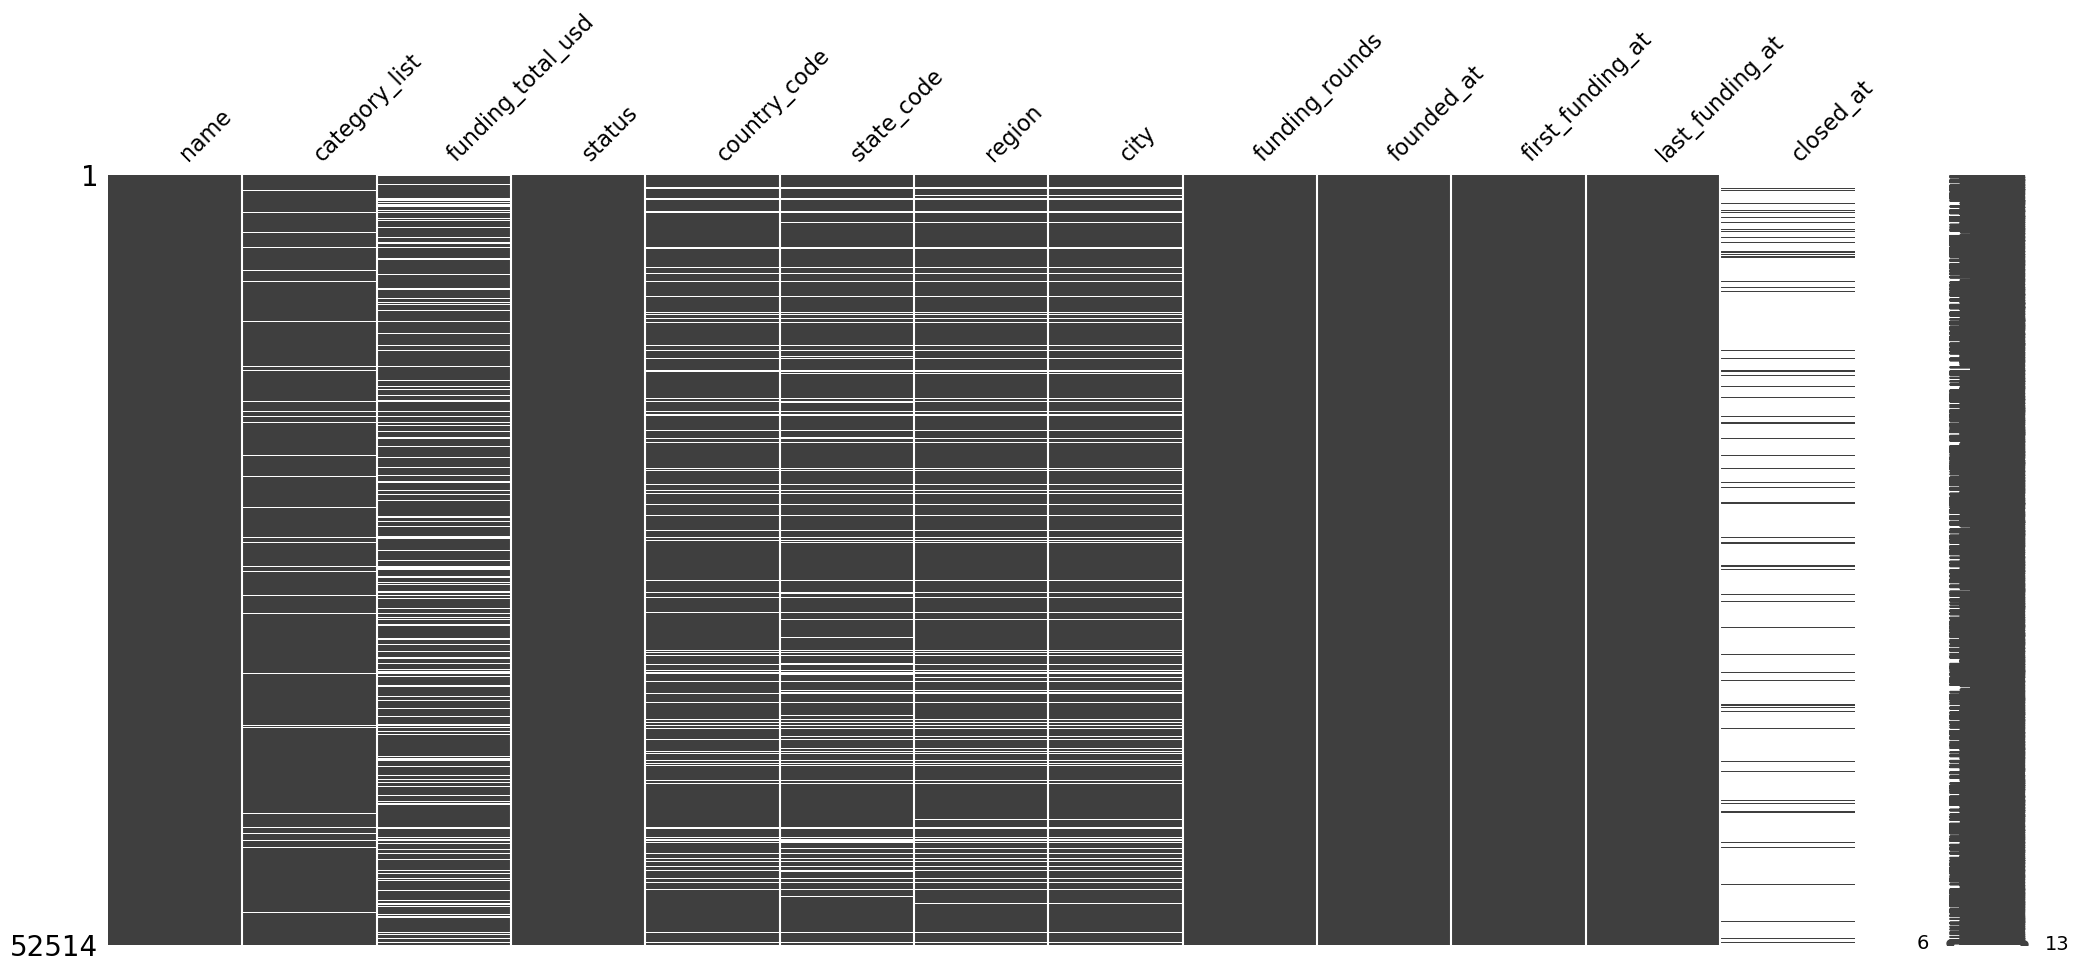

In [27]:
msno.matrix(train_df);

Распределение пропущенных значений в датасете выглядит случайным.

In [28]:
proportion_test = pd.Series((test_df.isna().sum() / len(test_df)).round(4) * 100, name='Доля')

In [29]:
omissions_test = pd.Series(test_df.isna().sum(), name='Пропуски')

In [30]:
pd.concat([omissions_test, proportion_test], axis=1)

,Пропуски,Доля
name,0,0.00
category_list,591,4.50
funding_total_usd,2578,19.64
country_code,1382,10.53
state_code,1695,12.91
region,1589,12.11
city,1587,12.09
funding_rounds,0,0.00
founded_at,0,0.00
first_funding_at,0,0.00


Построим матрицу пропущенных значений

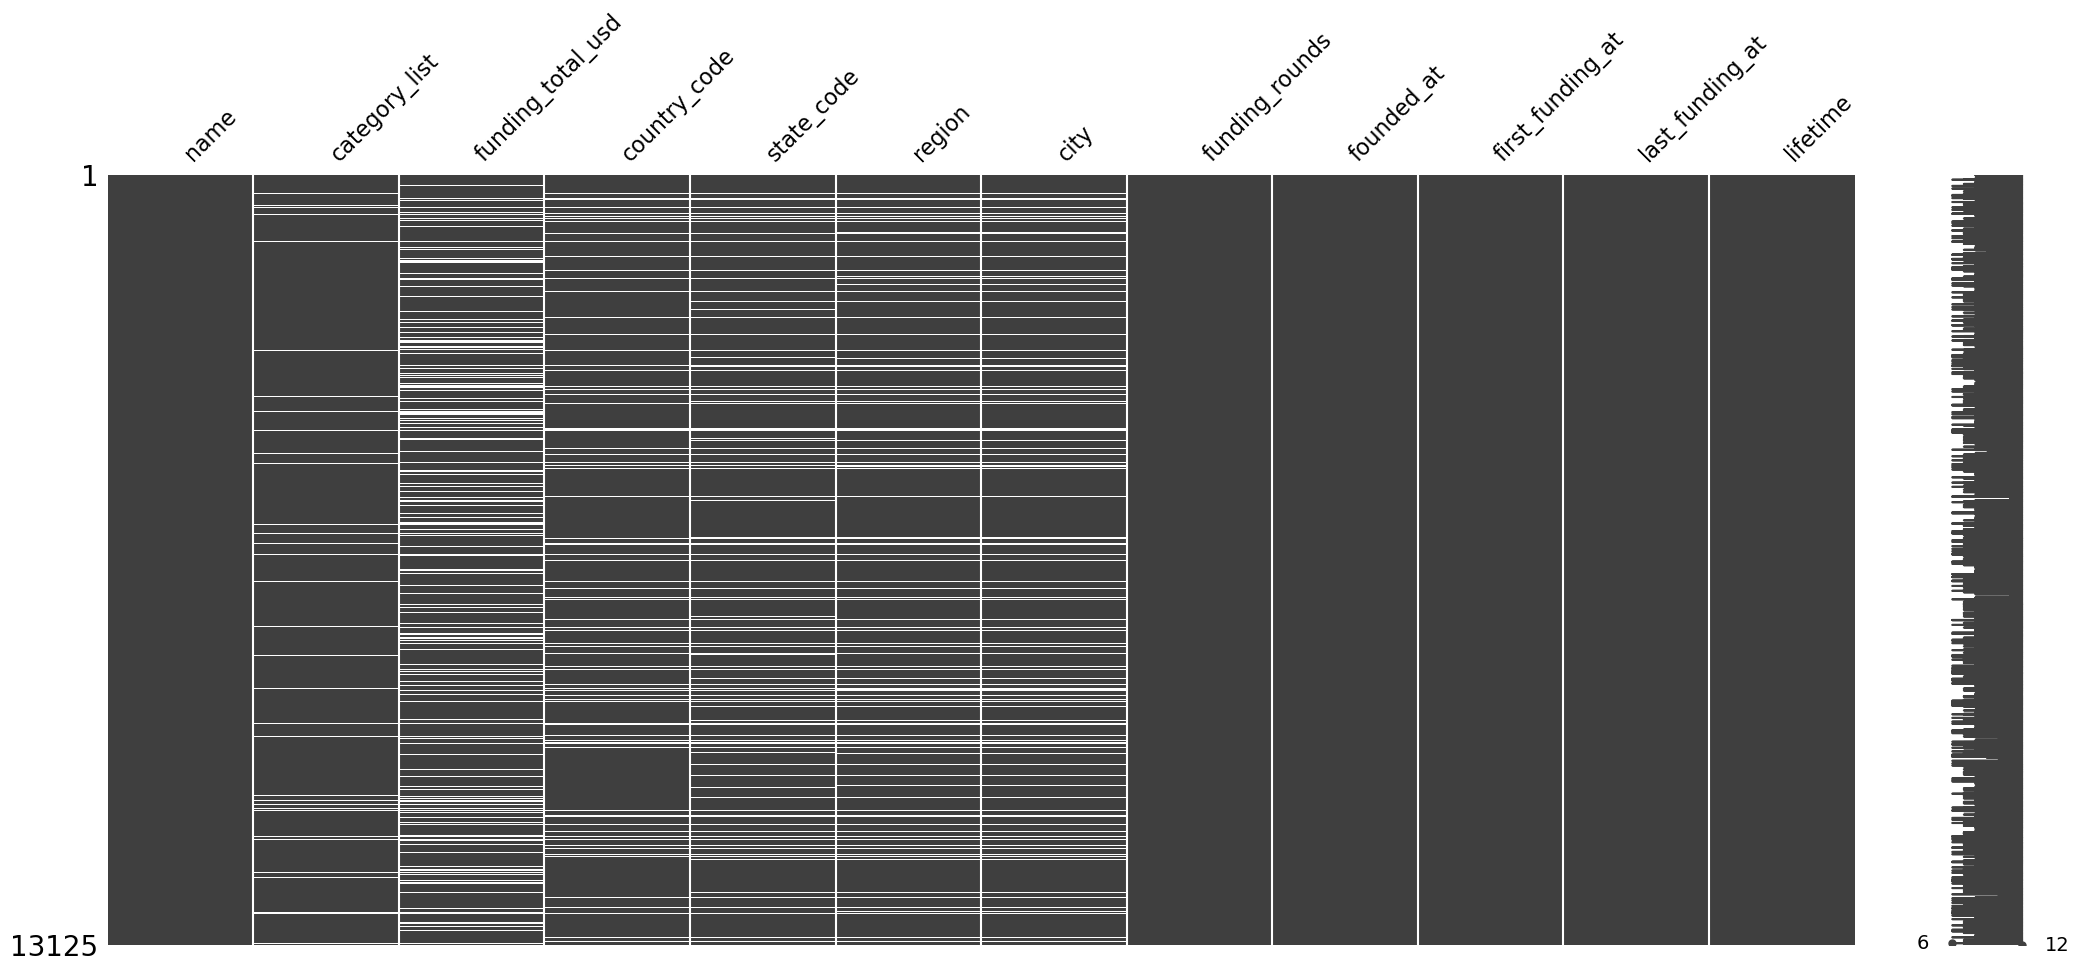

In [31]:
msno.matrix(test_df);

Распределение пропущенных значений в датасете выглядит случайным.

Пропущеные значения в `closed_at` можно объяснить тем, что на момент выгрузки данных, стартап не закрылся. Данный столбец можно заполнить днем выгрузки - 2018-01-01.

In [32]:
train_df['closed_at'] = train_df['closed_at'].fillna('2018-01-01')

Некоторые строки не будут нести пользную информацию, а именно те, в которых одноврменно есть пропущенные значения в следующих столбцах:
- `region`
- `city`
- `country_code`
- `state_code`

Такие строчки необходимо удалить. Для поиска таких строк была написана функция `index_na`, которая находит их индексы.

In [33]:
train_index_na = index_na(train_df) # вызываем функцию и находим индексы

Теперь удалим такие строчки.

In [34]:
train_df = train_df.drop(index=train_index_na).reset_index(drop=True)

Некоторые пропуски в столбце `category_list` можно заполнить основываясь на названиях компаний, то есть некоторые компании могут указывать в названии, чем они занимаются, например, в названиях могут присутсвовать следующие слова:
- `health`
- `medical`
- `software`
- `travel`
- `finance`
- `game`
- `technology`
- `sport`
- `restaurant`
- `transport`
- `e-commerce`
- `education`
- `marketing`

Перед тем как приступить к заполнению `category_list`, необходимо привести все названия компаний к одному регистру, но сразу де можно привести и все столбцы со строковыми данными, так как нам это понадобиться для поиска дубликатов. Также можно было заметить, что в столбце `name` есть один пропуск, надо на него посмотреть.

In [35]:
train_df[train_df['name'].isna() == 1] # Cмотрим на пропуски в столбце name

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
2915,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-03-31


Так как всё кроме названия известно, то данную строку удалять не будем, но необходимо заполнить пропуск, так как без этого не сможет заполнить `category_list`, поэтому заполним название значением `unknown`.

In [36]:
train_df['name'] = train_df['name'].fillna('unknown')

Сделаем проверку

In [37]:
train_df[train_df['name'].isna() == 1]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


Теперь приведем все столбцы со строками к нижнему регистру

In [38]:
columns_str = ['name', 'category_list', 'region', 'city', 'country_code', 'state_code']

In [39]:
for column in columns_str:
    train_df[column] = train_df[column].str.lower()
    test_df[column] = test_df[column].str.lower()

Можем приступать к заполнению столбца `catregory_list`. Для начала создадим список со всеми ключевыми словами.

In [40]:
tags = ['health', 'software', 'travel', 'finance', 'game', 'technology', 
        'sport', 'restaurant', 'transport', 'e-commerce', 'education', 'marketing']

In [41]:
for tag in tags:
    train_df.loc[(train_df['name'].str.contains(tag)) & (train_df['category_list'].isna()), 'category_list'] = tag
    test_df.loc[(test_df['name'].str.contains(tag)) & (test_df['category_list'].isna()), 'category_list'] = tag

Пропуски в столбцах `city`, `region`, `state_code` заполнятся новыми значениями, а имеено название страны `country_code` + `- other`, такая категория уже есть в датафрейме.

In [42]:
columns_other = ['city', 'region', 'state_code']

In [43]:
for other in columns_other:
    
    train_df.loc[train_df[other].isna(), other] = train_df['country_code'] + ' - other'
    test_df.loc[test_df[other].isna(), other] = test_df['country_code'] + ' - other'

Чтобы заполнить оставшиеся пропуски в столбце `category_list`, посмотрим на самую частую категорию в нем

In [44]:
train_df['category_list'].value_counts()

category_list
software                                                                3065
biotechnology                                                           2809
e-commerce                                                               971
clean technology                                                         840
mobile                                                                   826
                                                                        ... 
lifestyle|news|publishing|social network media                             1
crm|file sharing|software|training                                         1
apps|curated web|mobile|social media|social media marketing|software       1
cloud computing|enterprise software|hardware|photography                   1
online rental|parking|price comparison                                     1
Name: count, Length: 19993, dtype: int64

как видно это категория больше похожа на заглужку, поэтому все пропуски мы заполним такой же категорией, а затем сменим `category_list` на `startups`, такая категория есть в датафреймах.

In [45]:
train_df['category_list'] = train_df['category_list'].fillna('category_list')

In [46]:
test_df['category_list'] = test_df['category_list'].fillna('category_list')

In [47]:
train_df['category_list'] = train_df['category_list'].replace('category_list', 'startups')

In [48]:
test_df['category_list'] = test_df['category_list'].replace('category_list', 'startups')

Проверим еще раз на наличие пропусков.

In [49]:
train_df.isna().sum()

name                    0
category_list           0
funding_total_usd    8243
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
closed_at               0
dtype: int64

In [50]:
test_df.isna().sum()

name                    0
category_list           0
funding_total_usd    2578
country_code         1382
state_code           1382
region               1382
city                 1382
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

Пропущенные значения в столбце `funding_total_usd` в тренировочной выборки мы удалим.

In [51]:
train_df = train_df.dropna().reset_index(drop=True)

In [52]:
train_df.isna().sum()

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
founded_at           0
first_funding_at     0
last_funding_at      0
closed_at            0
dtype: int64

## Работа с явными дубликатами.

Сделаем проверку на дубликаты

In [53]:
train_df.duplicated().sum() # проверяем количество явных дубликатов

0

In [54]:
test_df.duplicated().sum() # проверяем количество явных дубликатов

0

Явные дубликаты необнаружены.

## Работа с неявными дубликатами.

Предположим, что в столбцах, имеющие строковый тип данных, одно и тоже значение переменной может быть написано по-разному, то есть проверим столбцы:
- `category_list`
- `country_code`
- `state_code`
- `region`
- `city`

Столбец `name` проверять на неявные дубликаты не будем, так как стартапы могут называться совершенно по-разному, даже если названия будут практически не отличаться между собой, то выяснить опечатка это или нет довольно сложно.

Так как `train_df` и `test_df` скорее всего раньше были одним датафреймом, то нет необходимости проверять оба, потому что есть провить самый больший (тренировочный) то в тестовом будут такие же ошибки.

In [55]:
train_df['country_code'].unique()

array(['che', 'usa', 'gbr', 'rus', 'kor', 'aus', 'twn', 'chn', 'can',
       'fin', 'bra', 'esp', 'egy', 'prt', 'isr', 'chl', 'svk', 'nld',
       'arg', 'jpn', 'irl', 'est', 'bel', 'mex', 'dnk', 'fra', 'ita',
       'grc', 'rom', 'deu', 'swe', 'tur', 'sgp', 'sau', 'mys', 'nga',
       'idn', 'qat', 'lbn', 'vnm', 'bgr', 'ind', 'uga', 'aut', 'pak',
       'are', 'nzl', 'lva', 'nor', 'ven', 'zaf', 'per', 'lux', 'pol',
       'jor', 'phl', 'nic', 'hkg', 'cze', 'isl', 'pan', 'mco', 'tha',
       'tto', 'ukr', 'ken', 'dza', 'ltu', 'cym', 'svn', 'hun', 'mus',
       'bgd', 'blr', 'slv', 'col', 'mlt', 'ury', 'gha', 'blz', 'cyp',
       'mmr', 'khm', 'gib', 'srb', 'hrv', 'dom', 'bwa', 'blm', 'pry',
       'bmu', 'lie', 'grd', 'uzb', 'geo', 'sen', 'alb', 'ecu', 'hnd',
       'zwe', 'bah', 'mda', 'tan', 'maf', 'cri', 'bhr', 'aze', 'mar',
       'lao', 'kwt', 'irn', 'gtm', 'ggy', 'kna', 'pri', 'omn', 'kaz',
       'tun', 'jam', 'npl', 'arm', 'tgo', 'rwa', 'som', 'cmr', 'mne',
       'syc', 'zmb']

В столбце `country_code` неявных дубликатов не обнаружено. Остальные столбцы просмотреть глазами довольно сложно, поэтому для такой ситуации воспользуемся расстоянием Левенштайна, которое ищет cходства между двумя строковыми последовательностями. Для этого написали функцию `lev_distance`, она рассчитывает расстояние Левенштайна и если отличие между двумя строками минимальное (1), то запоминает и возвращает эти строки.

In [56]:
category_uniq1, category_uniq2 = lev_distance(train_df['category_list'].unique())

теперь посмтрим на значения, которые практически совпадают между собой.

In [57]:
category_uniq1

array(['games', 'cloud computing|saas|software', 'sports',
       'cloud computing|enterprise software|iaas|saas',
       'cloud computing|enterprise software|iaas|saas',
       'mobile video|video streaming', 'game', 'game|mobile|startups',
       'games|software', 'saas',
       'cloud computing|enterprise software|paas|saas', 'spas',
       'mobile payments', 'mobile|payments',
       'business services|finance technology', 'games|mobile|startups',
       'shopping', 'cloud computing|enterprise software|iaas|paas',
       'entertainment|games|social media', 'apps|mobile|payments',
       'mobile|security', 'finance|technology',
       'cloud computing|cloud management|enterprise software|paas',
       'sport', 'finance technology', 'games|kids|parenting',
       'mobile security',
       'health care information technology|saas|software',
       'health and wellness|health care information technology',
       'enterprise software|health care|information technology',
       'health a

In [58]:
category_uniq2

array(['game', 'cloud computing|iaas|software', 'sport',
       'cloud computing|enterprise software|paas|saas',
       'cloud computing|enterprise software|iaas|paas',
       'mobile|video|video streaming', 'games', 'games|mobile|startups',
       'game|software', 'spas',
       'cloud computing|enterprise software|iaas|saas', 'saas',
       'mobile|payments', 'mobile payments',
       'business services|finance|technology', 'game|mobile|startups',
       'shipping', 'cloud computing|enterprise software|iaas|saas',
       'entertainment|game|social media', 'apps|mobile payments',
       'mobile security', 'finance technology',
       'cloud computing|cloud management|enterprise software|iaas',
       'sports', 'finance|technology', 'game|kids|parenting',
       'mobile|security',
       'health care|information technology|saas|software',
       'health and wellness|health care|information technology',
       'enterprise software|health care information technology',
       'health and 

Были найденны несколько неявных дубликатов, а именно:
- разные окончания у одинаковых слов `sport` и `sports`, `game` и `games`.
- ошибка в написании слова `health` - `mhealth`, `mobile|sns` и `mobile|sms`.
- разное написание `e-books` и `ebooks`
- а также разные разделители в одних и тех же категориях:
    - `health care|information technology|software` и `health care information technology|software`
    - `enterprise software|health care information technology` и `enterprise software|health care|information technology`
    - `health care|information technology|saas|software` и `health care information technology|saas|software`
    
исправим все эти неявные дубликаты

In [59]:
train_df['category_list'] = (
    train_df['category_list']
    .replace('games', value='game', regex=True)
    .replace('sports', value='sport', regex=True)
    .replace('ebooks', 'e-books')
    .replace('mhealth', 'helth')
    .replace('health care information technology|software', 'health care|information technology|software')
    .replace('enterprise software|health care information technology', 
             'enterprise software|health care|information technology')
    .replace('health care information technology|saas|software', 
             'health care|information technology|saas|software')
)

Аналогичные ошибки испрвим в тестовом

In [60]:
test_df['category_list'] = (
    test_df['category_list']
    .replace('games', value='game', regex=True)
    .replace('sports', value='sport', regex=True)
    .replace('ebooks', 'e-books')
    .replace('mhealth', 'helth')
    .replace('health care information technology|software', 'health care|information technology|software')
    .replace('enterprise software|health care information technology', 
             'enterprise software|health care|information technology')
    .replace('health care information technology|saas|software', 
             'health care|information technology|saas|software')
)

Теперь проверим столбец `region`

In [61]:
region_uniq1, region_uniq2 = lev_distance(train_df['region'].unique())

In [62]:
region_uniq1

array(['rus - other', 'rus - other', 'york', 'aus - other', 'aus - other',
       'aus - other', 'melbourne', 'fin - other', 'vt - other',
       'vt - other', 'vt - other', 'vt - other', 'in - other',
       'in - other', 'in - other', 'in - other', 'in - other',
       'in - other', 'in - other', 'in - other', 'in - other',
       'in - other', 'fra - other', 'bra - other', 'bra - other',
       'chn - other', 'chn - other', 'chn - other', 'montpelier',
       'ita - other', 'esp - other', 'nj - other', 'nj - other',
       'nj - other', 'nj - other', 'nj - other', 'nj - other',
       'nj - other', 'nj - other', 'nj - other', 'bangalore',
       'can - other', 'can - other', 'can - other', 'ca - other',
       'ca - other', 'ca - other', 'ca - other', 'ca - other',
       'ca - other', 'ca - other', 'ca - other', 'ca - other',
       'ca - other', 'isr - other', 'wa - other', 'wa - other',
       'wa - other', 'wa - other', 'wa - other', 'wa - other',
       'wa - other', 'wa - othe

In [63]:
region_uniq2

array(['aus - other', 'mus - other', 'cork', 'rus - other', 'mus - other',
       'aut - other', 'melbourn', 'in - other', 'ut - other',
       'va - other', 'ct - other', 'mt - other', 'fin - other',
       'ind - other', 'id - other', 'on - other', 'mn - other',
       'idn - other', 'il - other', 'tn - other', 'ia - other',
       'irn - other', 'bra - other', 'fra - other', 'bwa - other',
       'can - other', 'che - other', 'chl - other', 'montpellier',
       'ia - other', 'est - other', 'ny - other', 'nb - other',
       'nc - other', 'ns - other', 'ne - other', 'nh - other',
       'nm - other', 'nv - other', 'nd - other', 'mangalore',
       'chn - other', 'ca - other', 'tan - other', 'can - other',
       'wa - other', 'ma - other', 'va - other', 'ct - other',
       'pa - other', 'co - other', 'la - other', 'ga - other',
       'ia - other', 'isl - other', 'ca - other', 'ma - other',
       'va - other', 'wi - other', 'pa - other', 'wy - other',
       'la - other', 'ga - ot

В столбце `region` было замечено несколько неправильных написаний:
- `melbourne` и `melbourn`
- `montpellier` и `montpelier`
- `monterrey` и `monterey`
- `lyon` и `leon`

Также исправим это

In [64]:
train_df['region'] = (
    train_df['region']
    .replace('melbourn', 'melbourne')
    .replace('montpelier', 'montpellier')
    .replace('monterey', 'monterrey')
    .replace('leon', 'lyon')
)

In [65]:
test_df['region'] = (
    test_df['region']
    .replace('melbourn', 'melbourne')
    .replace('montpelier', 'montpellier')
    .replace('monterey', 'monterrey')
    .replace('leon', 'lyon')
)

Изучим столбец `city`

In [66]:
city_uniq1, city_uniq2 = lev_distance(train_df['city'].unique())

In [67]:
city_uniq1

array(['zürich', 'san jose', 'houston', 'tampa', 'austin', 'oakland',
       'boston', 'boston', 'york', 'aus - other', 'shanghai', 'melbourne',
       'reston', 'reston', 'reston', 'reston', 'london', 'columbia',
       'beijing', 'cambridge', 'fargo', 'fargo', 'charlestown', 'tallinn',
       'broomfield', 'broomfield', 'lowell', 'paris', 'lafayette', 'rome',
       'pittsburgh', 'brussels', 'stamford', 'stamford', 'stow',
       'bristol', 'rus - other', 'roma', 'roma', 'chn - other',
       'chn - other', 'chn - other', 'raleigh', 'china', 'china',
       'irvine', 'charleston', 'kuala lumpur', 'fra - other', 'renton',
       'renton', 'renton', 'renton', 'clifton', 'surry hills', 'sofia',
       'guildford', 'lanham', 'camden', 'west end', 'bangalore',
       'montréal', 'can - other', 'can - other', 'hangzhou', 'hangzhou',
       'exton', 'berlin', 'mclean', 'greendale', 'newtown', 'saint-cloud',
       'redmond', 'lagos', 'lyon', 'lyon', 'rye', 'geneva', 'moncton',
       'bedfo

In [68]:
city_uniq2

array(['zurich', 'san josé', 'hosston', 'nampa', 'tustin', 'oaklands',
       'toston', 'bolton', 'cork', 'rus - other', 'shangai', 'melbourn',
       'renton', 'weston', 'preston', 'creston', 'lindon', 'colombia',
       'beijin', 'ambridge', 'largo', 'faro', 'charleston', 'tallinna',
       'brookfield', 'bloomfield', 'powell', 'parisi', 'la fayette',
       'roma', 'pittsburg', 'brussel', 'stafford', 'stanford', 'stowe',
       'bristow', 'aus - other', 'rome', 'roca', 'can - other',
       'che - other', 'chl - other', 'rayleigh', 'chiba', 'chino',
       'irving', 'charlestown', 'kuala lumpor', 'bra - other', 'reston',
       'trenton', 'denton', 'fenton', 'clinton', 'surrey hills', 'sofiya',
       'guilford', 'latham', 'hamden', 'west bend', 'mangalore',
       'montreal', 'chn - other', 'tan - other', 'yangzhou', 'changzhou',
       'oxton', 'oberlin', 'mc lean', 'greenvale', 'newton',
       'saint cloud', 'edmond', 'lages', 'nyon', 'lynn', 'ryde', 'genova',
       'monkton', 

Как можно заметить в этом столбце также присутсвуют дубликаты, названия одних и тех же городов написаны по-разному:
- `zürich` и `zurich`
- `san josé` и `san jose`
- `shanghan` и `shanghai`
- `shangai` и `shanghai`
- `oporto` и `porto`
- `charles town` и `charlestown`
- `tallinna` и `tallinn`
- `pittsburg` и `pittsburgh`
- `roma` и `rome`
- `kuala lumpor` и `kuala lumpur`
- `sofia` и `sofiya`
- `seville` и `sevilla`
- `sidney` и `sydney`
- `media` и `medina`
- `fairlawn` и `fair lawn`
- `quebeck` и `quebec`

Также еще есть названия, которые отличаются только одним символом, но такие города и правда существуют (проверено)

In [69]:
train_df['city'] = (
    train_df['city']
    .replace('zürich', 'zurich')
    .replace('san josé', 'san jose')
    .replace('shanghan', 'shanghai')
    .replace('shangai', 'shanghai')
    .replace('oporto', 'porto')
    .replace('charles town', 'charlestown')
    .replace('tallinna', 'tallinn')
    .replace('pittsburg', 'pittsburgh')
    .replace('roma', 'rome')
    .replace('kuala lumpor', 'kuala lumpur')
    .replace('sofia', 'sofiya')
    .replace('seville', 'sevilla')
    .replace('sidney', 'sydney')
    .replace('media', 'medina')
    .replace('fairlawn', 'fair lawn')
    .replace('quebeck', 'quebec')
)

In [70]:
test_df['city'] = (
    test_df['city']
    .replace('zürich', 'zurich')
    .replace('san josé', 'san jose')
    .replace('shanghan', 'shanghai')
    .replace('shangai', 'shanghai')
    .replace('oporto', 'porto')
    .replace('charles town', 'charlestown')
    .replace('tallinna', 'tallinn')
    .replace('pittsburg', 'pittsburgh')
    .replace('roma', 'rome')
    .replace('kuala lumpor', 'kuala lumpur')
    .replace('sofia', 'sofiya')
    .replace('seville', 'sevilla')
    .replace('sidney', 'sydney')
    .replace('media', 'medina')
    .replace('fairlawn', 'fair lawn')
    .replace('quebeck', 'quebec')
)

Проверяем столбец `state_code`

In [71]:
state_uniq1, state_uniq2 = lev_distance(train_df['state_code'].unique())

In [72]:
state_uniq1

array(['25', '25', '25', ..., 'u6', 'u6', 'u6'], dtype=object)

In [73]:
state_uniq2

array(['q5', 'c5', '23', ..., 'u1', 'v6', 'd6'], dtype=object)

В столбце `state_code` неявных дубликатов не обнаружено, так как большинство штатов (областей и тп.) могут иметь любые обозначения, также и одинаковые и отличающиеся на один символ.

## Добавление новых столбцов

Добавим новый столбец `main_category` в датафреймы, который будет содежрать основную деятельность стартапа. В `category_list` указана вся деятельность стартапов, то можно предположить, что первая область их действия это основная. Для того, чтобы выделить основную категорию, была написана функция `first_value`, которая принимает столбец и отделят каждую категорию.

In [74]:
train_df['main_category'] = train_df['category_list'].apply(first_value)

In [75]:
test_df['main_category'] = test_df['category_list'].apply(first_value)

Создадим столбец `category`, в который войдут обобщенные категории всех категорий из `category_list`. Все категории был обобщены на 9 категорий:
- `it`
- `analytic`
- `health`
- `financy`
- `industrial`
- `science and education`
- `transport and travel`
- `entertainment industry`
- `socially`

p.s В индустрию развлечений я также отнес рестораны. В транспорт добавил категории связанные с недвижимостью. В категорию `socially` вошло все, что не попадает под остальные, например, спорт, еда, свадьбы, ЖКХ и тп.

In [76]:
train_df['category'] = train_df['category_list'].apply(general_category)

In [77]:
test_df['category'] = test_df['category_list'].apply(general_category)

Создадим столбец `lifetime`, в котором хранится время существования стартапа в днях. Для этого из столбца `closed_at` вычтем `founded_at`.

In [78]:
train_df['lifetime'] = (train_df['closed_at'] - train_df['founded_at']).dt.days

Так даты скорее всего будут сильно коррелировать между собой, создадим на их основе новые столбцы, где будут месяцы основания, месяцы первого финансирования, дни последнего финансирования и год закрытия(он скорее всего удалится, так как будет сильно коррелировать с `lifetime`)

In [79]:
train_df['month_founded'] = train_df['founded_at'].apply(lambda x: x.month)

In [80]:
train_df['month_first_fun'] = train_df['first_funding_at'].apply(lambda x: x.month)

In [81]:
train_df['day_last_fun'] = train_df['last_funding_at'].apply(lambda x: x.day)

In [82]:
train_df['year_closed'] = train_df['closed_at'].apply(lambda x: x.year)

Также добавим еще три столбца с датами, в которых будет разница меду датой основания и первым раундом финансирования, датой основания и последним раундом финансирования, разница между первым и последним раундом финансирования в днях.

In [83]:
train_df['foun_first_fun_day'] = (train_df['first_funding_at'] - train_df['founded_at']).dt.days

In [84]:
train_df['foun_last_fun_day'] = (train_df['last_funding_at'] - train_df['founded_at']).dt.days

In [85]:
train_df['fun_first_last_day'] = (train_df['last_funding_at'] - train_df['first_funding_at']).dt.days

Такие же столбцы, кроме даты закрытия создадим и в тестовго датафрейме.

In [86]:
test_df['month_founded'] = test_df['founded_at'].apply(lambda x: x.month)

In [87]:
test_df['month_first_fun'] = test_df['first_funding_at'].apply(lambda x: x.month)

In [88]:
test_df['day_last_fun'] = test_df['last_funding_at'].apply(lambda x: x.day)

In [89]:
test_df['foun_first_fun_day'] = (test_df['first_funding_at'] - test_df['founded_at']).dt.days

In [90]:
test_df['foun_last_fun_day'] = (test_df['last_funding_at'] - test_df['founded_at']).dt.days

In [91]:
test_df['fun_first_last_day'] = (test_df['last_funding_at'] - test_df['first_funding_at']).dt.days

Также добавим столбец с частями света, нам известны страны `country_code` и на основе этого столбца создадим столбец `part_world`, для этого была написана функция `category_world`. Всего будет 8 категорий, некоторое уточнение страны карибского моря я отнес к центральной америке, Россия отнесена к Европе, Бермуды отнес к Северной Америке:
- `europa`
- `north america`
- `asia`
- `south america`
- `central america`
- `east`
- `australia and oceania`
- `africa`

In [92]:
train_df['part_world'] = train_df['country_code'].apply(category_world)

In [93]:
test_df['part_world'] = test_df['country_code'].apply(category_world)

Проверим результат, выведим первые 5 столбцов

In [94]:
train_df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,category,lifetime,month_founded,month_first_fun,day_last_fun,year_closed,foun_first_fun_day,foun_last_fun_day,fun_first_last_day,part_world
0,lunchgate,online reservations|restaurants,828626.0,operating,che,25,zurich,zurich,2,2009-12-31,...,entertainment industry,2923,12,5,1,2018,486,1796,1310,europa
1,earlens,manufacturing|medical|medical devices,42935019.0,operating,usa,ca,sf bay area,redwood city,4,2005-01-01,...,health,4748,1,5,25,2018,1949,3342,1393,north america
2,reviva pharmaceuticals,biotechnology,35456381.0,operating,usa,ca,sf bay area,san jose,3,2006-01-01,...,industrial,4383,1,8,2,2018,2423,3104,681,north america
3,connected sports ventures,mobile,4300000.0,operating,usa,nj,newark,princeton,1,2011-01-20,...,financy,2538,1,11,12,2018,662,662,0,north america
4,attensity,analytics|business analytics|social crm|social...,90000000.0,operating,usa,ca,sf bay area,redwood city,1,2000-01-01,...,analytic,6575,1,5,14,2018,5247,5247,0,north america


In [95]:
test_df.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,lifetime,main_category,category,month_founded,month_first_fun,day_last_fun,foun_first_fun_day,foun_last_fun_day,fun_first_last_day,part_world
0,crystalsol,clean technology,2819200.0,nic,17,nic - other,nic - other,1,2008-06-01,2009-07-01,...,3501,clean technology,industrial,6,7,1,395,395,0,central america
1,jbi fish & wings,hospitality,NaN,usa,tn,tn - other,humboldt,1,2010-07-25,2010-07-28,...,2717,hospitality,health,7,7,28,3,3,0,north america
2,coinplus,finance,428257.0,lux,3,esch-sur-alzette,esch-sur-alzette,2,2014-06-16,2014-05-15,...,1295,finance,financy,6,5,18,-32,94,126,europa
3,imagine communications,software|video|video streaming,34700000.0,usa,ca,san diego,san diego,4,2005-01-01,2005-01-01,...,4748,software,entertainment industry,1,1,20,0,1935,1935,north america
4,dna13,software,4530000.0,can,on,ottawa,ottawa,1,2001-01-01,2007-05-08,...,6209,software,it,1,5,8,2318,2318,0,north america


## Вывод

На данном этапе были сделаны следующие действия:

1. Изменили тип данных столбцов `first_funding_at`, `last_funding_at`, `founded_at` и `closed_at` с `object` на `datetime` во всех датафреймах
2. Сделали проверку на пропуски и избавлись от них следующим способом:
    - В таблице `train_df` в столбце `closed_at` заполнили днем выгрузки данных, так как пропуски образовались из-за того, что стартапы на момент выгрузки не закрылись.
    - Удалили строчки, которые в сумме не будут нести пользную информацию, а именно те, в которых одноврменно есть пропущенные значения в следующих столбцах: `region`, `city`, `country_code` и `state_code`
    - В столбце `category_list` некоторые пропуски заполнили основываясь на названиях компаний, то есть некоторые компании могут указывать в названии, чем они занимаются.
    - В таблице `train_df` в столбце `name` был один пропуск, но все остальные столбцы были заполнены, поэтому заполнили название заглужкой `unknown`
    - В столбцах `city`, `region` и `state_code` заполнили новыми значениями, а имеено название страны `country_code` + ` - other`, сделали так на основе такой же категории в других столбцах.
    - Оставшиеся пропуски в `category_list` заполнили модой, а именно `category_list` и затем заменили эту категории на другую категорию в этом столбце `startups`
    - Удалили пропуски в `funding_total_usd` в тренировочной выборке, в тестовой выборке они будут заполняться в пайплане.
3. Сделали проверку на явные дубликаты - **не обнаружены.**
4. Сделали проверку на неявные дубликаты, неявные дубликаты, кроме столбца `country_code`, определяли при помощи расстояния Левенштайна и затем исправили их:
    - В столбце `category_list` были найдены дубликаты. Разные окончания у одинаковых слов, ошибки в написанни слов, разное написание одних и тех же категорий и разные разделители в категориях:
        - `sport` и `sports`, `game` и `games`
        - `health` - `mhealth`, `mobile|sns` и `mobile|sms`
        - `e-books` и `ebooks`
        - `health care|information technology|software` и `health care information technology|software`
        - `enterprise software|health care information technology` и `enterprise software|health care|information technology`
        - `health care|information technology|saas|software` и `health care information technology|saas|software`
    - В столбце `region` были найдены дубликаты. Разные написание одних и тех же городов:
        - `melbourne` и `melbourn`
        - `montpellier` и `montpelier`
        - `monterrey` и `monterey`
        - `lyon` и `leon`
    - В столбце `city` также были найдены множество дубликатов.
    - В столбце `state_code` дубликаты не были найдены
    - В столбце `country_code` дубликаты не найдены.
5. Были добавлены новые столбцы:
    - Столбец `lifetime` был добавлен в `train_df`, в котором храниться время существования стартапа в днях. 
    - Столбец `main_category` в датафреймы, который будет содежрать основную деятельность стартапа.
    - Столбец `category`, в который войдут обобщенные категории всех категорий из `category_list`. Все категории был обобщены на 9 категорий.
    - Cтолбец `founded_month`, хранит месяцы основания, 
    - Столбец `month_first_fun` хранит месяцы первого финансирования, 
    - Столбец `day_last_fun` хранит дни последнего финансирования 
    - Столбец `year_closed` хранит год закрытия
    - Столбец `foun_first_fun_day`  разница меду датой основания и первым раундом финансирования, 
    - Столбец `foun_last_fun_day` разница датой основания и последним раундом финансирования
    - Столбец `fun_first_last_day` разница между первым и последним раундом финансирования в днях.
    - Столбец `part_world` в него вошли страны по частям света. Является обобщением столбца `country_code`. Всего будет 8 категорий.
6. Пропуски, которые не удалось заполнить в столбце `funding_total_usd` - удалили.

# Исследовательский анализ данных.

Исследуем данные в датафрейме `train_df`:
- Посмотрим на соотношение целевого признака - `status`
- Посмотрим на соотношение частей мира - `part_world` и `category`
- Изучим количественные переменные: `funding_total_usd`, `funding_rounds` и `lifetime` в зависимости от статуса стартапа
- Разделим данные на временные ряды и панельные данные и изучим их

Исследуем данные в датафрейме `test_df`:
- Посмотрим на соотношение частей мира - `part_world` и `category`
- Изучим количественные переменные: `funding_total_usd`, `funding_rounds` и `lifetime`
- Разделим данные на временные ряды и панельные данные и изучим их

## Анализ `train_df`

Сгруппируем данные по статусу и частей света, а затем построим круговую диаграмму.

In [96]:
status_startup = train_df.groupby('status')['name'].count()

In [97]:
part_world = train_df.groupby('part_world')['name'].count()

In [98]:
category = train_df.groupby('category')['name'].count()

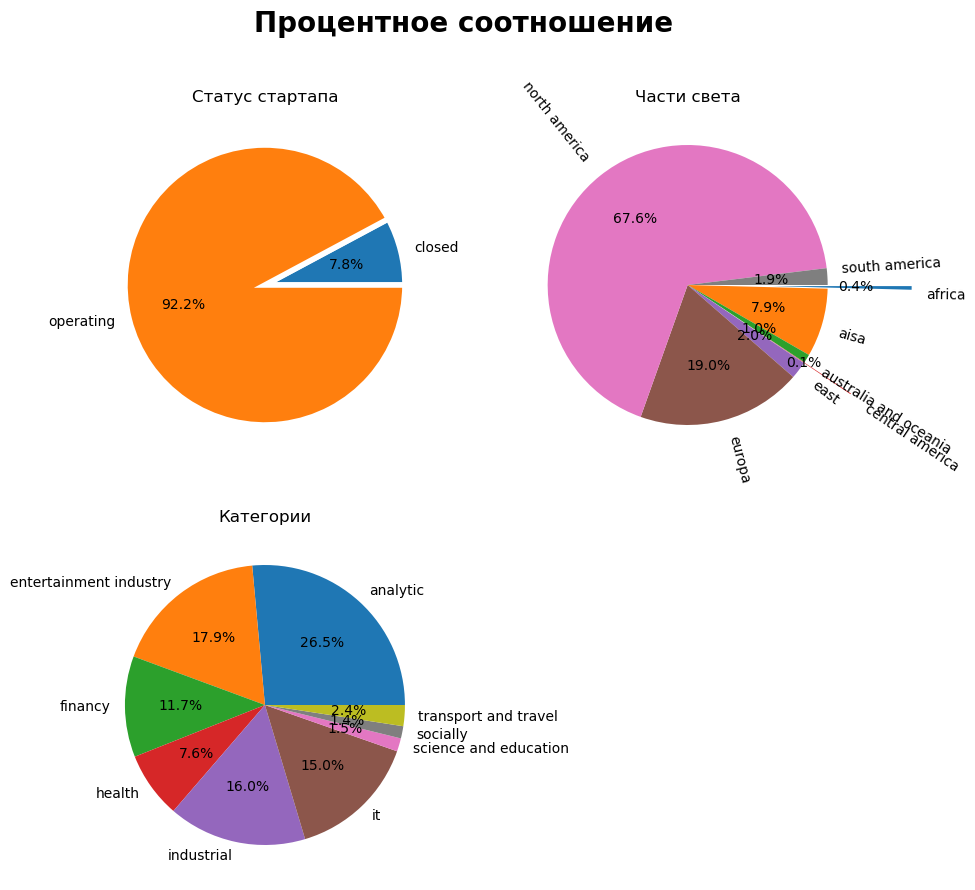

In [99]:
plt.figure(figsize=(10, 10))

plt.suptitle('Процентное соотношение', fontsize=20, fontweight='bold')

plt.subplot(2, 2, 1)
plt.pie(status_startup.values,
       labels=status_startup.index,
       wedgeprops={'linewidth':4, 'edgecolor':'white'},
       autopct='%.1f%%')
plt.title('Статус стартапа')

plt.subplot(2, 2, 2)
plt.pie(part_world.values,
       labels=part_world.index,
       autopct='%.1f%%', rotatelabels=True, counterclock=False,
       explode=[0.6, 0, 0, 0.4, 0, 0, 0, 0])
plt.title('Части света')

plt.subplot(2, 2, 3)
plt.pie(category.values,
       labels=category.index,
       autopct='%.1f%%')
plt.title('Категории');

Только 7% стартапов закрыты в датафрейме `train_df`.

Cоотношение частей света следующие:
- `north america` - 66.7%
- `europa` - 19.4%
- `asia` - 8.5%
- `east` - 2%
- `south america` - 1.9%
- `australia and oceania` - 1%
- `africa` - 0.5%
- `cenral america` - 0.1%

Соотношение категорий:
- `analytic` - 25.9%
- `entertainment industry` - 19.3%
- `industrial` - 15%
- `it` - 14.4%
- `financy` - 11.6%
- `health` - 7.7%
- `transport and travel` - 2.9%
- `science and education` - 1.6%
- `socially` - 1.5%

Теперь изучим количественные перменные и сначала построим диаграмму размаха.

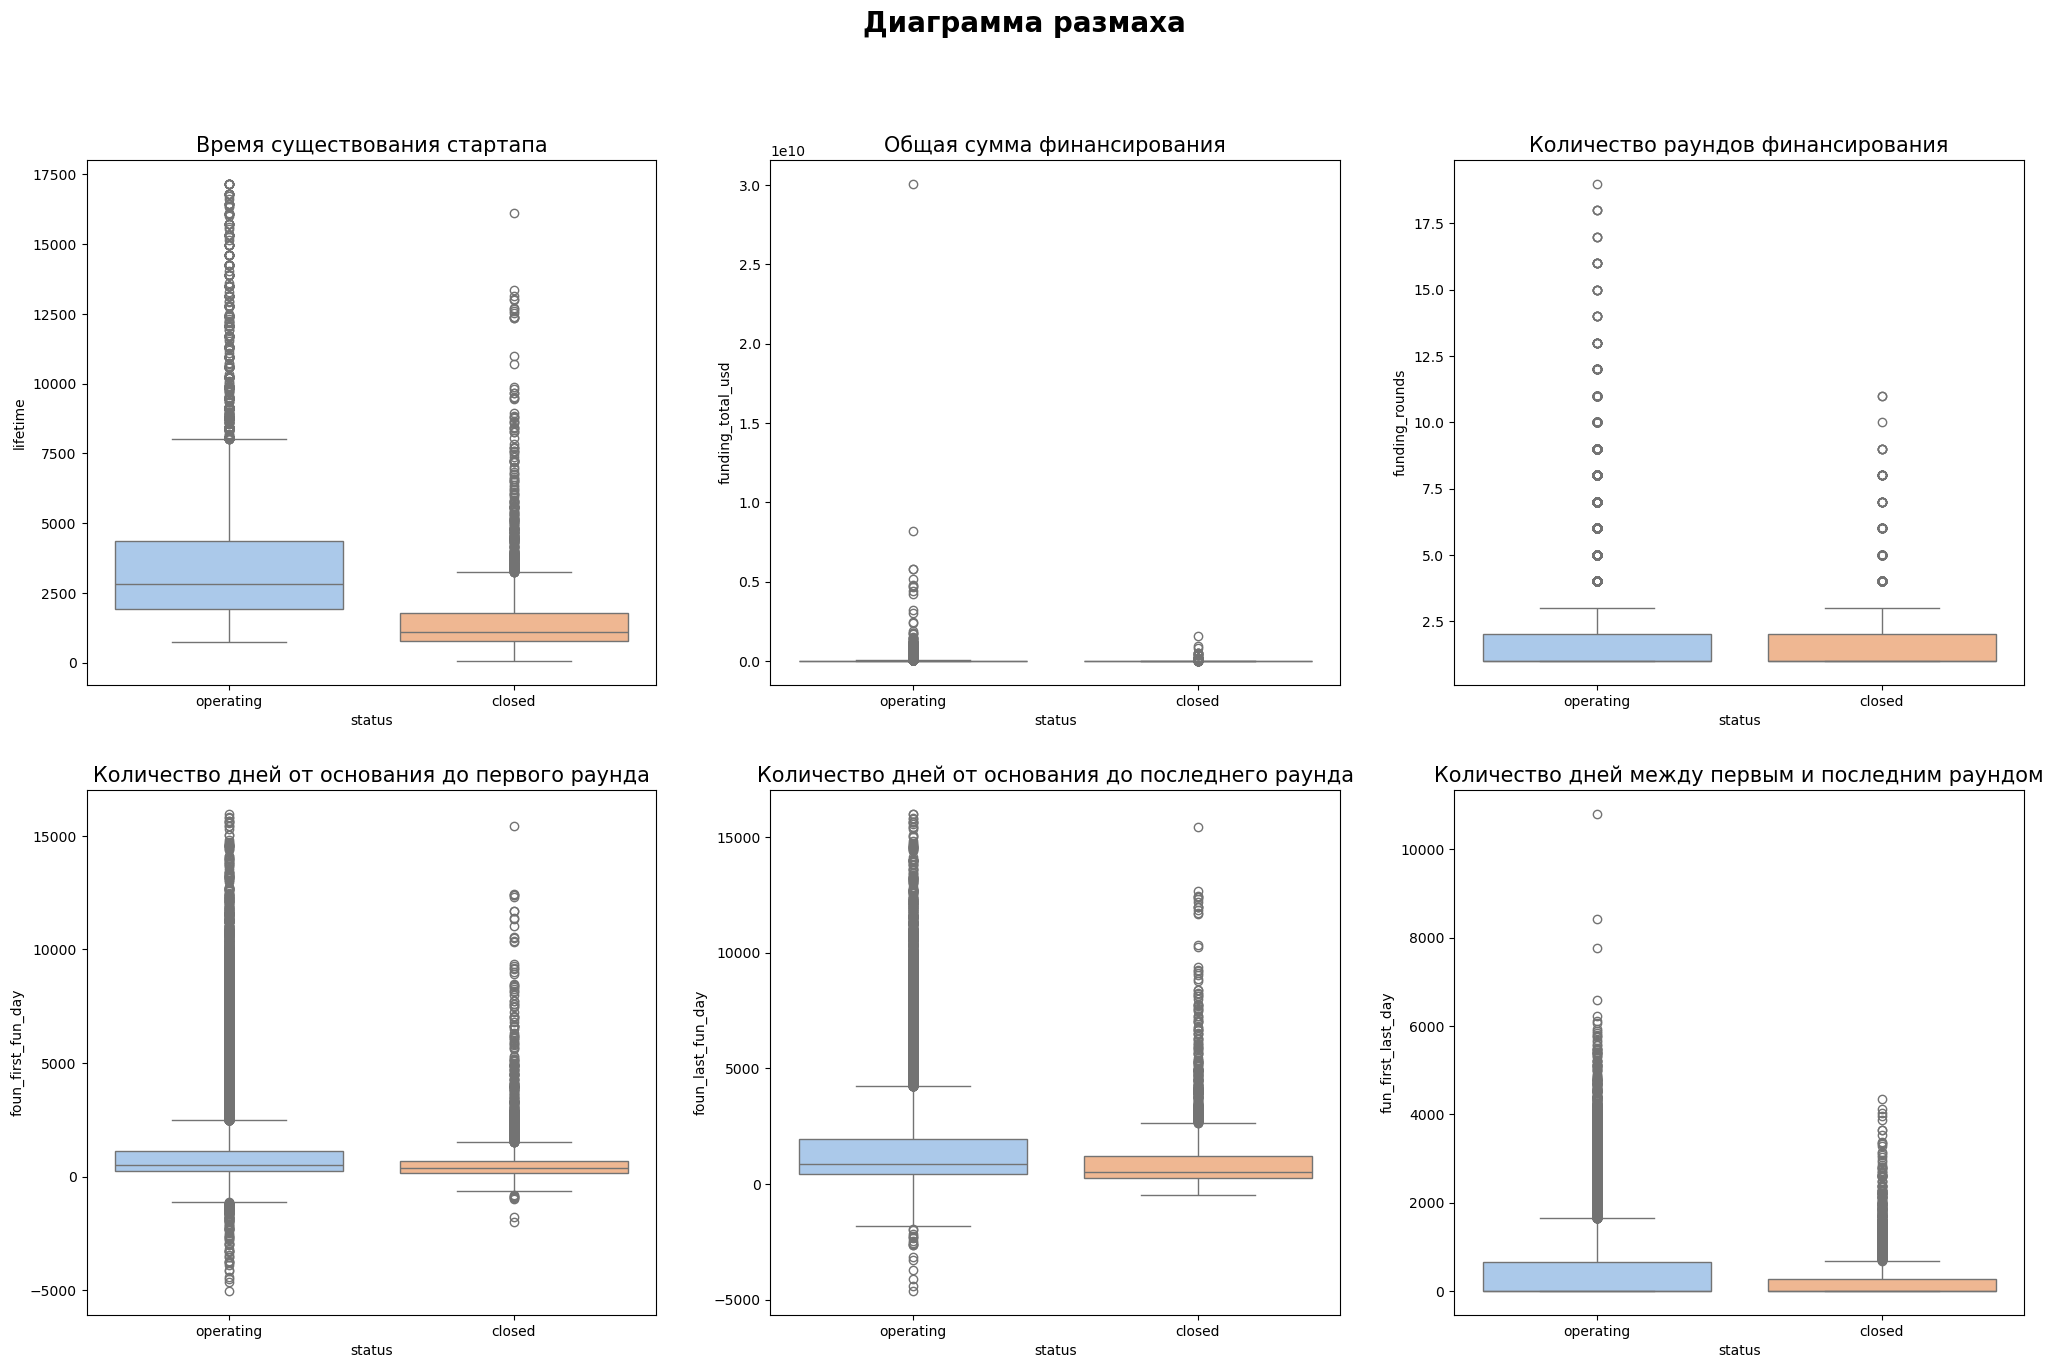

In [100]:
plt.figure(figsize=(25, 15))

plt.suptitle('Диаграмма размаха', fontsize=20, fontweight='bold')

plt.subplot(2, 3, 1)
sns.boxplot(x='status', y='lifetime', data=train_df, 
            palette='pastel', hue='status', legend=False)
plt.title('Время существования стартапа', fontsize=15)

plt.subplot(2, 3, 2)
sns.boxplot(x='status', y='funding_total_usd', data=train_df, 
            palette='pastel', hue='status', legend=False)
plt.title('Общая сумма финансирования', fontsize=15)

plt.subplot(2, 3, 3)
sns.boxplot(x='status', y='funding_rounds', data=train_df, 
            palette='pastel', hue='status', legend=False)
plt.title('Количество раундов финансирования', fontsize=15)

plt.subplot(2, 3, 4)
sns.boxplot(x='status', y='foun_first_fun_day', data=train_df, 
            palette='pastel', hue='status', legend=False)
plt.title('Количество дней от основания до первого раунда', fontsize=15)

plt.subplot(2, 3, 5)
sns.boxplot(x='status', y='foun_last_fun_day', data=train_df, 
            palette='pastel', hue='status', legend=False)
plt.title('Количество дней от основания до последнего раунда', fontsize=15)

plt.subplot(2, 3, 6)
sns.boxplot(x='status', y='fun_first_last_day', data=train_df, 
            palette='pastel', hue='status', legend=False)
plt.title('Количество дней между первым и последним раундом', fontsize=15);

Посмотрим на распределение наших величин

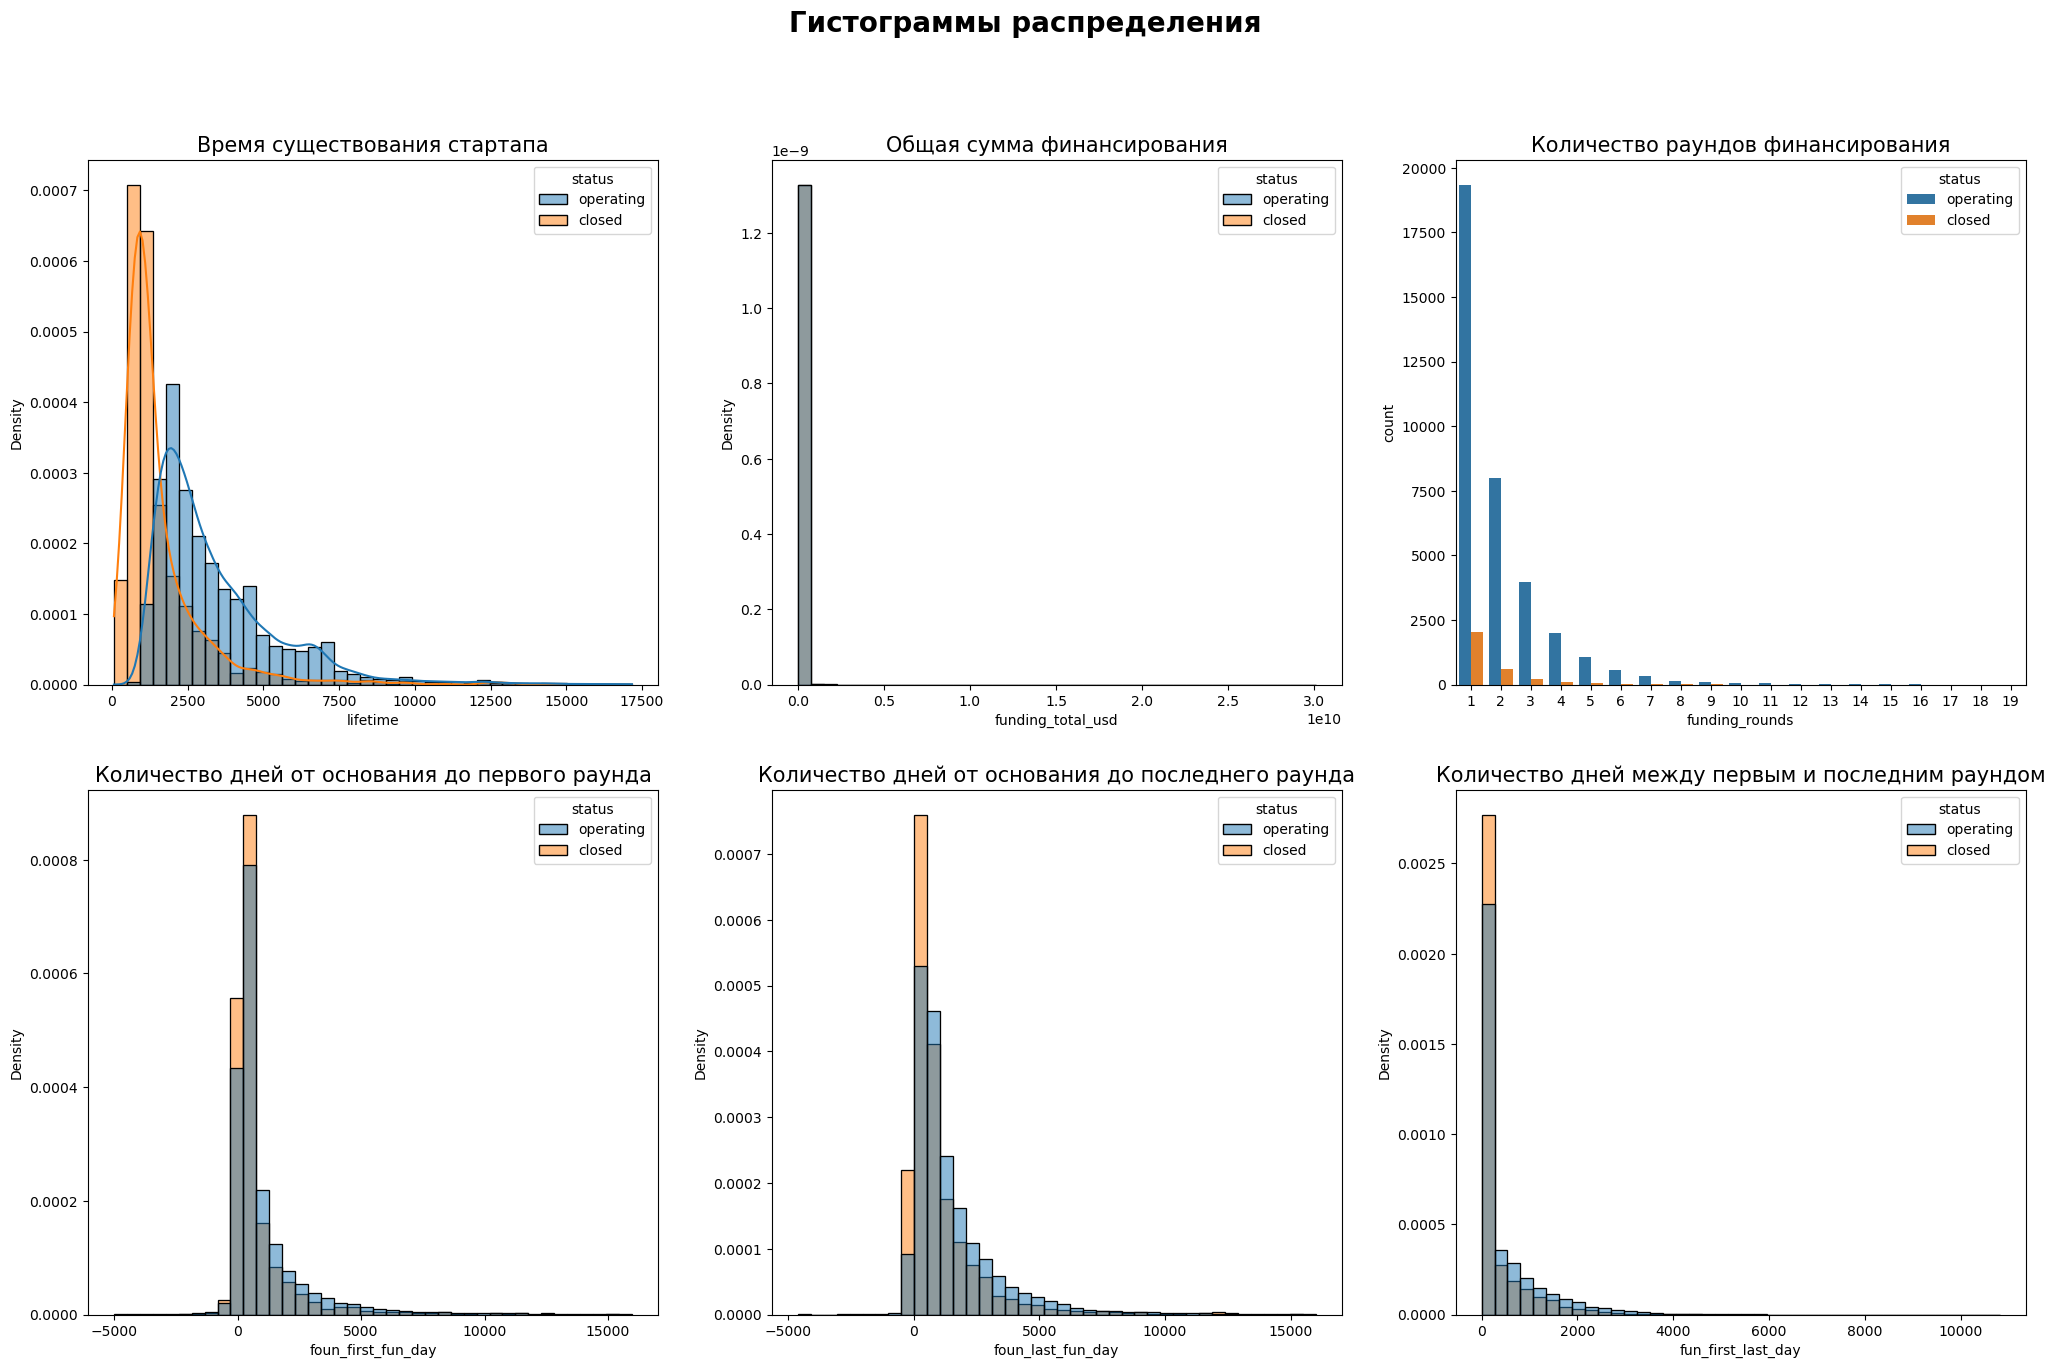

In [101]:
plt.figure(figsize=(25, 15))

plt.suptitle('Гистограммы распределения', fontsize=20, fontweight='bold')

plt.subplot(2, 3, 1)
sns.histplot(data=train_df, x='lifetime', hue='status', 
             stat='density', common_norm=False, kde=True, bins=40)
plt.title('Время существования стартапа', fontsize=15)

plt.subplot(2, 3, 2)
sns.histplot(data=train_df, x='funding_total_usd', hue='status', 
             stat='density', common_norm=False, bins=40)
plt.title('Общая сумма финансирования', fontsize=15)

plt.subplot(2, 3, 3)
sns.countplot(data=train_df, x='funding_rounds', hue='status')
plt.title('Количество раундов финансирования', fontsize=15)

plt.subplot(2, 3, 4)
sns.histplot(data=train_df, x='foun_first_fun_day', hue='status',
            stat='density', common_norm=False, bins=40)
plt.title('Количество дней от основания до первого раунда', fontsize=15)

plt.subplot(2, 3, 5)
sns.histplot(data=train_df, x='foun_last_fun_day', hue='status',
            stat='density', common_norm=False, bins=40)
plt.title('Количество дней от основания до последнего раунда', fontsize=15)

plt.subplot(2, 3, 6)
sns.histplot(data=train_df, x='fun_first_last_day', hue='status',
            stat='density', common_norm=False, bins=40)
plt.title('Количество дней между первым и последним раундом', fontsize=15);

Сказать хоть что-то о выбросах невозможно, так как сумма финасирования может значительно отличаться от разных компаний, так и количество раундов может быть любым. При маленькой разнице между датой основания и первым раундом/последним раундом стартапы чаще закрываются, аналогично при разнице между первым и последним раундом. Как видно из гистограмм данные распределены ненормально, но чтобы быть уверенными в этом проведем статистический тест.

Для того, чтобы убедится, что данные распределены ненормально воспользуемся тестом Шапиро-Уилка. Для этого была написана функция `normality_chek`.

Нобходимо выдвинуть гипотезы о нормальности:

**H0** - данные распределены нормально

**H1** - данные распределены ненормально.

In [102]:
normality_chek(train_df['lifetime'])

Отвергаем H0. Ненормальное распределение


In [103]:
normality_chek(train_df['funding_total_usd'])

Отвергаем H0. Ненормальное распределение


In [104]:
normality_chek(train_df['funding_rounds'])

Отвергаем H0. Ненормальное распределение


In [105]:
normality_chek(train_df['foun_first_fun_day'])

Отвергаем H0. Ненормальное распределение


In [106]:
normality_chek(train_df['foun_last_fun_day'])

Отвергаем H0. Ненормальное распределение


In [107]:
normality_chek(train_df['fun_first_last_day'])

Отвергаем H0. Ненормальное распределение


Теперь создадим панельные данные по статусу и каждому из годов

In [108]:
pdata_ff = train_df.groupby(['status', 'month_first_fun'])['name'].count()

# Сделаем таблицу
pdata_ff = pd.DataFrame(pdata_ff)

# Сделаем данные по статусу отдельными столбцами
pdata_ff_unstacked = pdata_ff.name.unstack(level = 0)

In [109]:
pdata_f = train_df.groupby(['status', 'month_founded'])['name'].count()

# Сделаем таблицу
pdata_f = pd.DataFrame(pdata_f)

# Сделаем данные по статусу отдельными столбцами
pdata_f_unstacked = pdata_f.name.unstack(level = 0)

In [110]:
pdata_lf = train_df.groupby(['status', 'day_last_fun'])['name'].count()

# Сделаем таблицу
pdata_lf = pd.DataFrame(pdata_lf)

# Сделаем данные по статусу отдельными столбцами
pdata_lf_unstacked = pdata_lf.name.unstack(level = 0)

In [111]:
pdata_c = train_df.groupby(['status', 'closed_at'])['name'].count()

# Сделаем таблицу
pdata_c = pd.DataFrame(pdata_c)

# Сделаем данные по статусу отдельными столбцами
pdata_c_unstacked = pdata_c.name.unstack(level = 0)

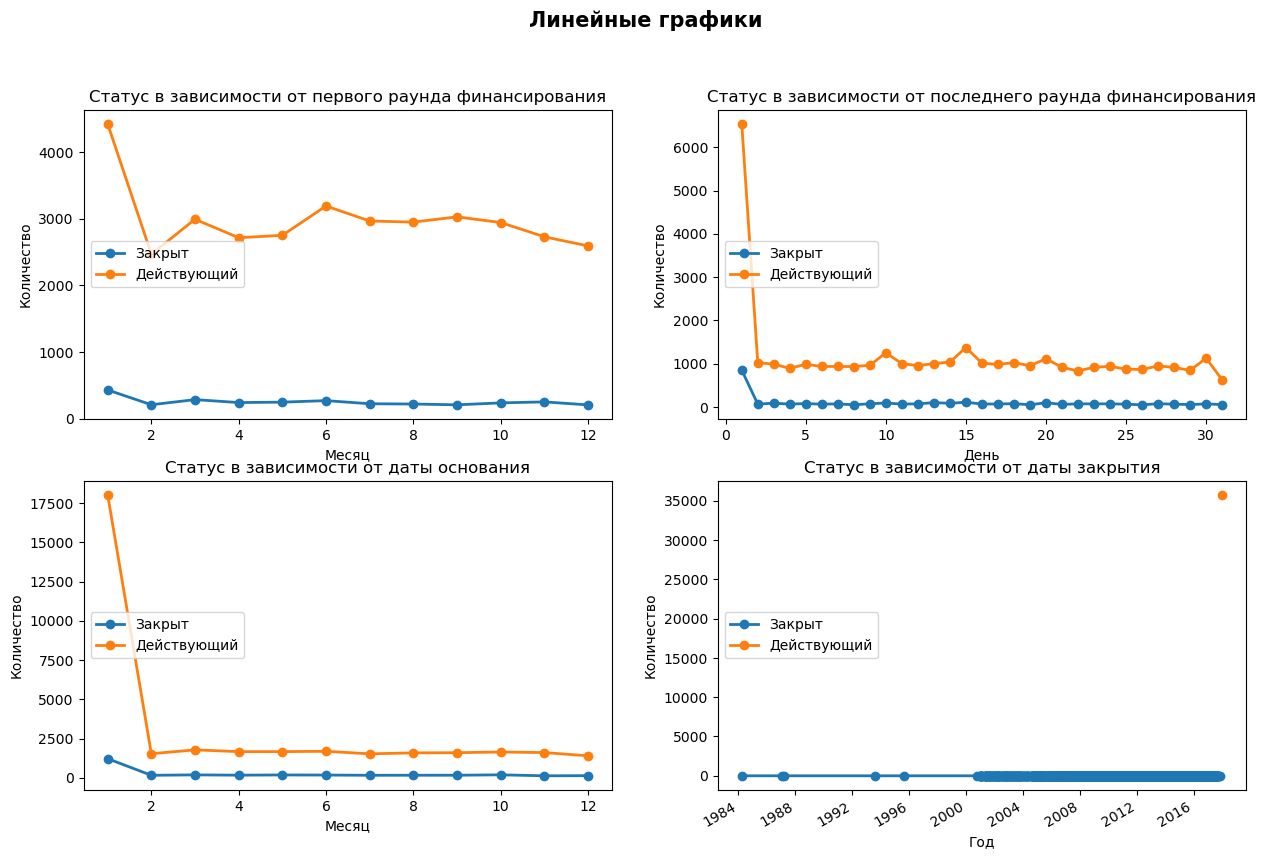

In [112]:
# зададим размер графика
plt.figure(figsize = (15, 10))

plt.suptitle('Линейные графики', fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
pdata_ff_unstacked.closed.plot(linewidth = 2, marker = 'o', label = 'Закрыт')
pdata_ff_unstacked.operating.plot(linewidth = 2, marker = 'o', label = 'Действующий')
plt.xlabel('Месяц')
plt.ylabel('Количество',)
plt.title('Статус в зависимости от первого раунда финансирования')
plt.legend(loc = 'center left')

plt.subplot(2, 2, 2)
pdata_lf_unstacked.closed.plot(linewidth = 2, marker = 'o', label = 'Закрыт')
pdata_lf_unstacked.operating.plot(linewidth = 2, marker = 'o', label = 'Действующий')
plt.xlabel('День')
plt.ylabel('Количество',)
plt.title('Статус в зависимости от последнего раунда финансирования')
plt.legend(loc = 'center left')

plt.subplot(2, 2, 3)
pdata_f_unstacked.closed.plot(linewidth = 2, marker = 'o', label = 'Закрыт')
pdata_f_unstacked.operating.plot(linewidth = 2, marker = 'o', label = 'Действующий')
plt.xlabel('Месяц')
plt.ylabel('Количество',)
plt.title('Статус в зависимости от даты основания')
plt.legend(loc = 'center left')

plt.subplot(2, 2, 4)
pdata_c_unstacked.closed.plot(linewidth = 2, marker = 'o', label = 'Закрыт')
pdata_c_unstacked.operating.plot(linewidth = 2, marker = 'o', label = 'Действующий')
plt.xlabel('Год')
plt.ylabel('Количество',)
plt.title('Статус в зависимости от даты закрытия')
plt.legend(loc = 'center left')

plt.show()

Видно, что в какие-то месяцы в финансировании первого раунда выделяются, аналогичная ситуация с днями последненго финансирования, но в целом все выглядит одинаково, просто действующих стартапов больше. Можно также отметить, что много стартапов открываются в начале года (первый месяц) из-за этого первые раунди финансирования также больше в начале года. Последние раунды финансирования часто происходят в начале месяца. Также можно сказать, что начиная с 2000 годов стали чаще открывать стартапы и эта цифра с каждым годом растет. С увеличением стартапов, они также стали и чаще закрываться.

## Анализ `test_df`

Сделаем такой же анализ `test_df` и изучим количественные данные и соотношение частей света и категорий.

In [113]:
part_world_test = test_df.groupby('part_world')['name'].count()

In [114]:
category_test = test_df.groupby('category')['name'].count()

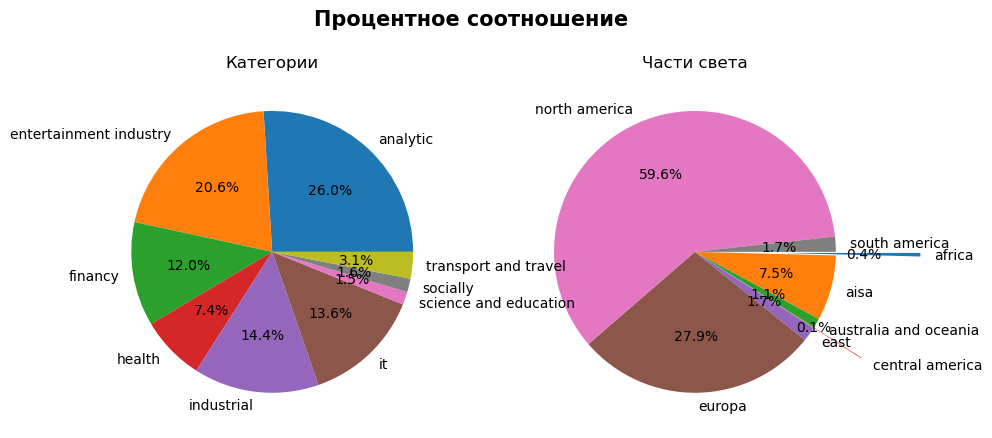

In [115]:
plt.figure(figsize=(10, 5))

plt.suptitle('Процентное соотношение', fontsize=15, fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(part_world_test.values,
       labels=part_world_test.index,
       autopct='%.1f%%', counterclock=False,
       explode=[0.6, 0, 0, 0.4, 0, 0, 0, 0])
plt.title('Части света')

plt.subplot(1, 2, 1)
plt.pie(category_test.values,
       labels=category_test.index,
       autopct='%.1f%%')
plt.title('Категории');

Получили слудющие соотношения:
- `north america` - 66.7%
- `europa` - 19.4%
- `asia` - 8.4%
- `south america` - 2%
- `east` - 1.9%
- `australia and oceania` - 1.2%
- `africa` - 0.4%
- `cenral america` - 0.1%

Соотношение категорий:
- `analytic` - 26.3%
- `entertainment industry` - 18.6%
- `industrial` - 15%
- `it` - 14.1%
- `financy` - 12.2%
- `health` - 7.7%
- `transport and travel` - 3.1%
- `science and education` - 1.5%
- `socially` - 1.5%

Изучим количественные данные и начнем с диаграммы размаха

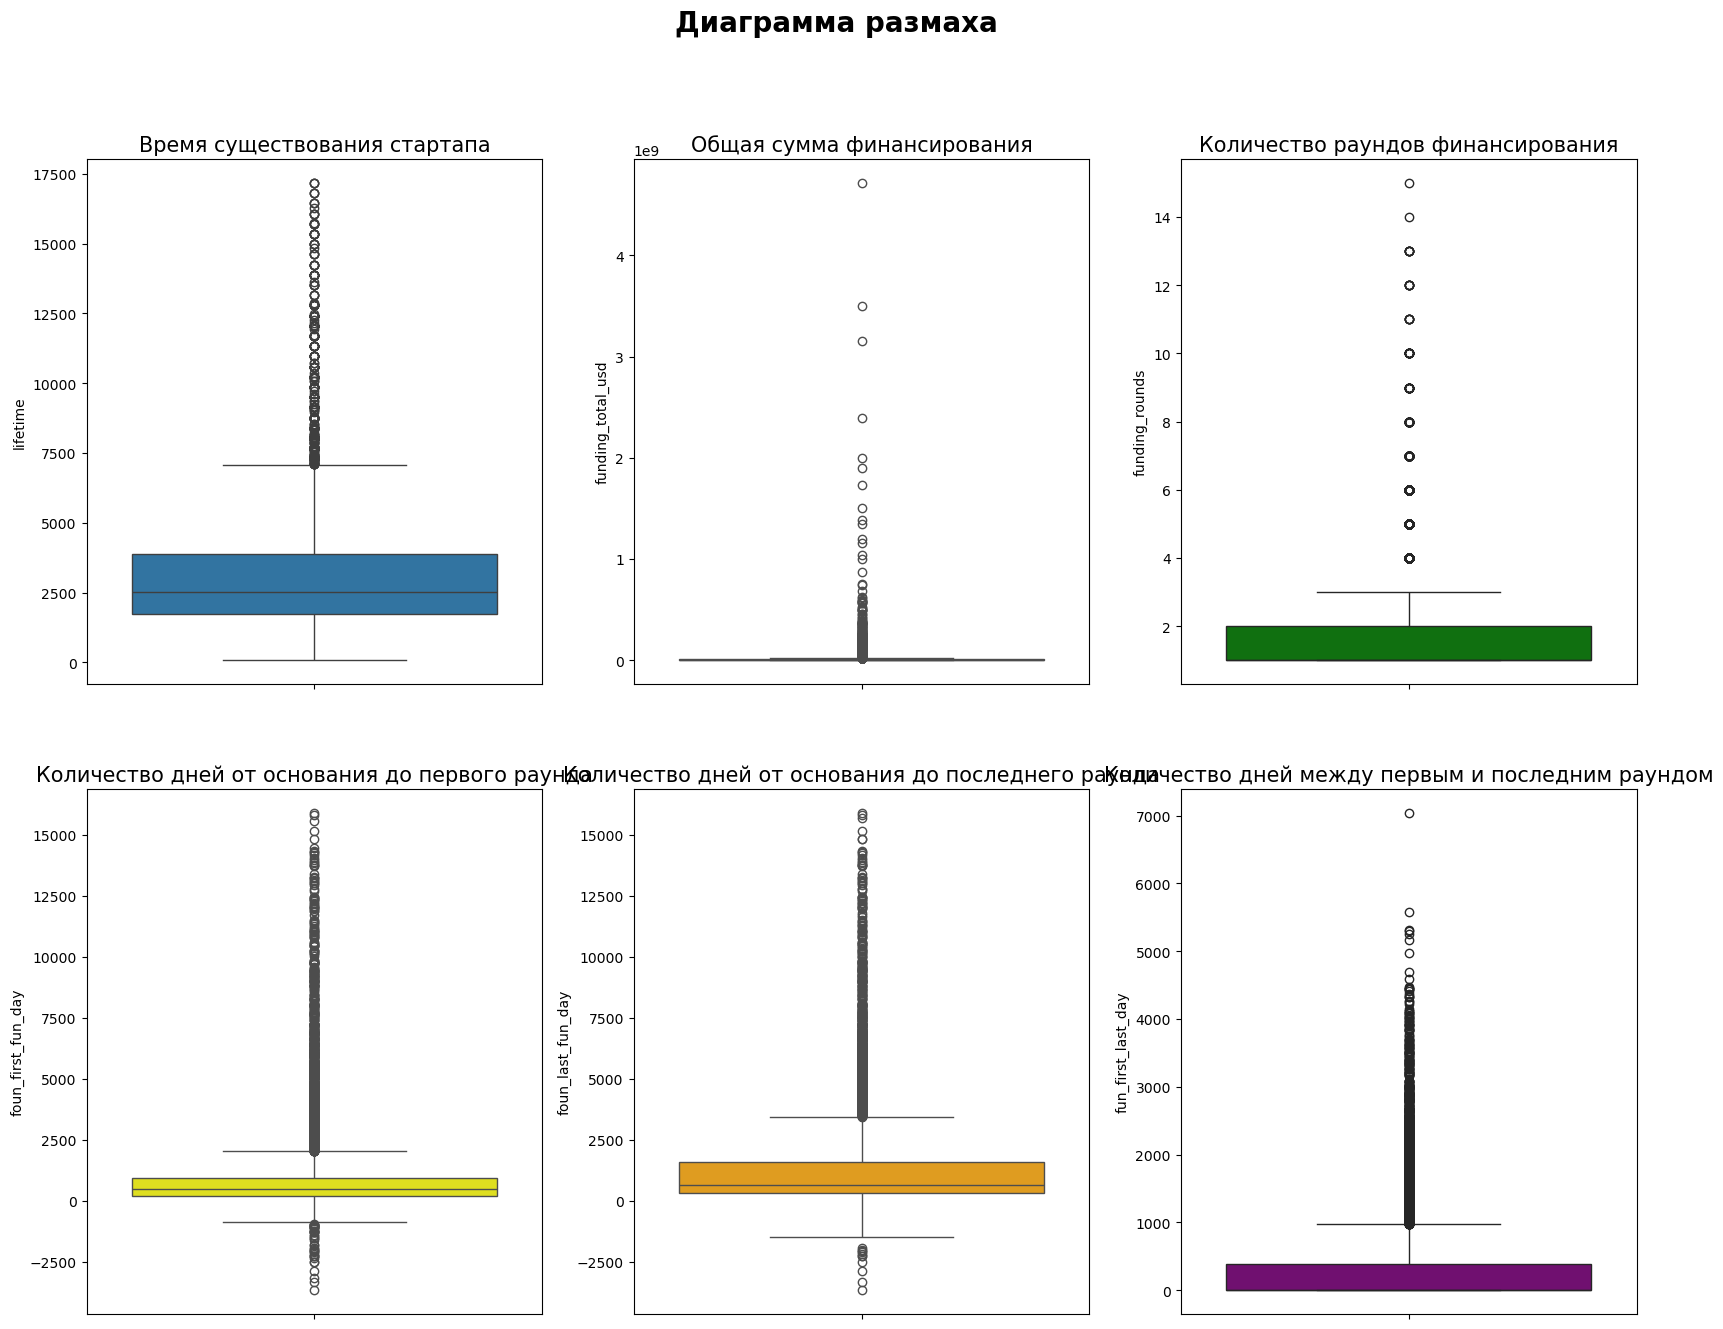

In [116]:
plt.figure(figsize=(20, 15))

plt.suptitle('Диаграмма размаха', fontsize=20, fontweight='bold')

plt.subplot(2, 3, 1)
sns.boxplot(y='lifetime', data=test_df)
plt.title('Время существования стартапа', fontsize=15)

plt.subplot(2, 3, 2)
sns.boxplot(y='funding_total_usd', data=test_df, color='red')
plt.title('Общая сумма финансирования', fontsize=15)

plt.subplot(2, 3, 3)
sns.boxplot(y='funding_rounds', data=test_df, color='green')
plt.title('Количество раундов финансирования', fontsize=15)

plt.subplot(2, 3, 4)
sns.boxplot(y='foun_first_fun_day', data=test_df, color='yellow')
plt.title('Количество дней от основания до первого раунда', fontsize=15)

plt.subplot(2, 3, 5)
sns.boxplot(y='foun_last_fun_day', data=test_df, color='orange')
plt.title('Количество дней от основания до последнего раунда', fontsize=15)

plt.subplot(2, 3, 6)
sns.boxplot(y='fun_first_last_day', data=test_df, color='purple')
plt.title('Количество дней между первым и последним раундом', fontsize=15);

Теперь посмотрим на их распределение

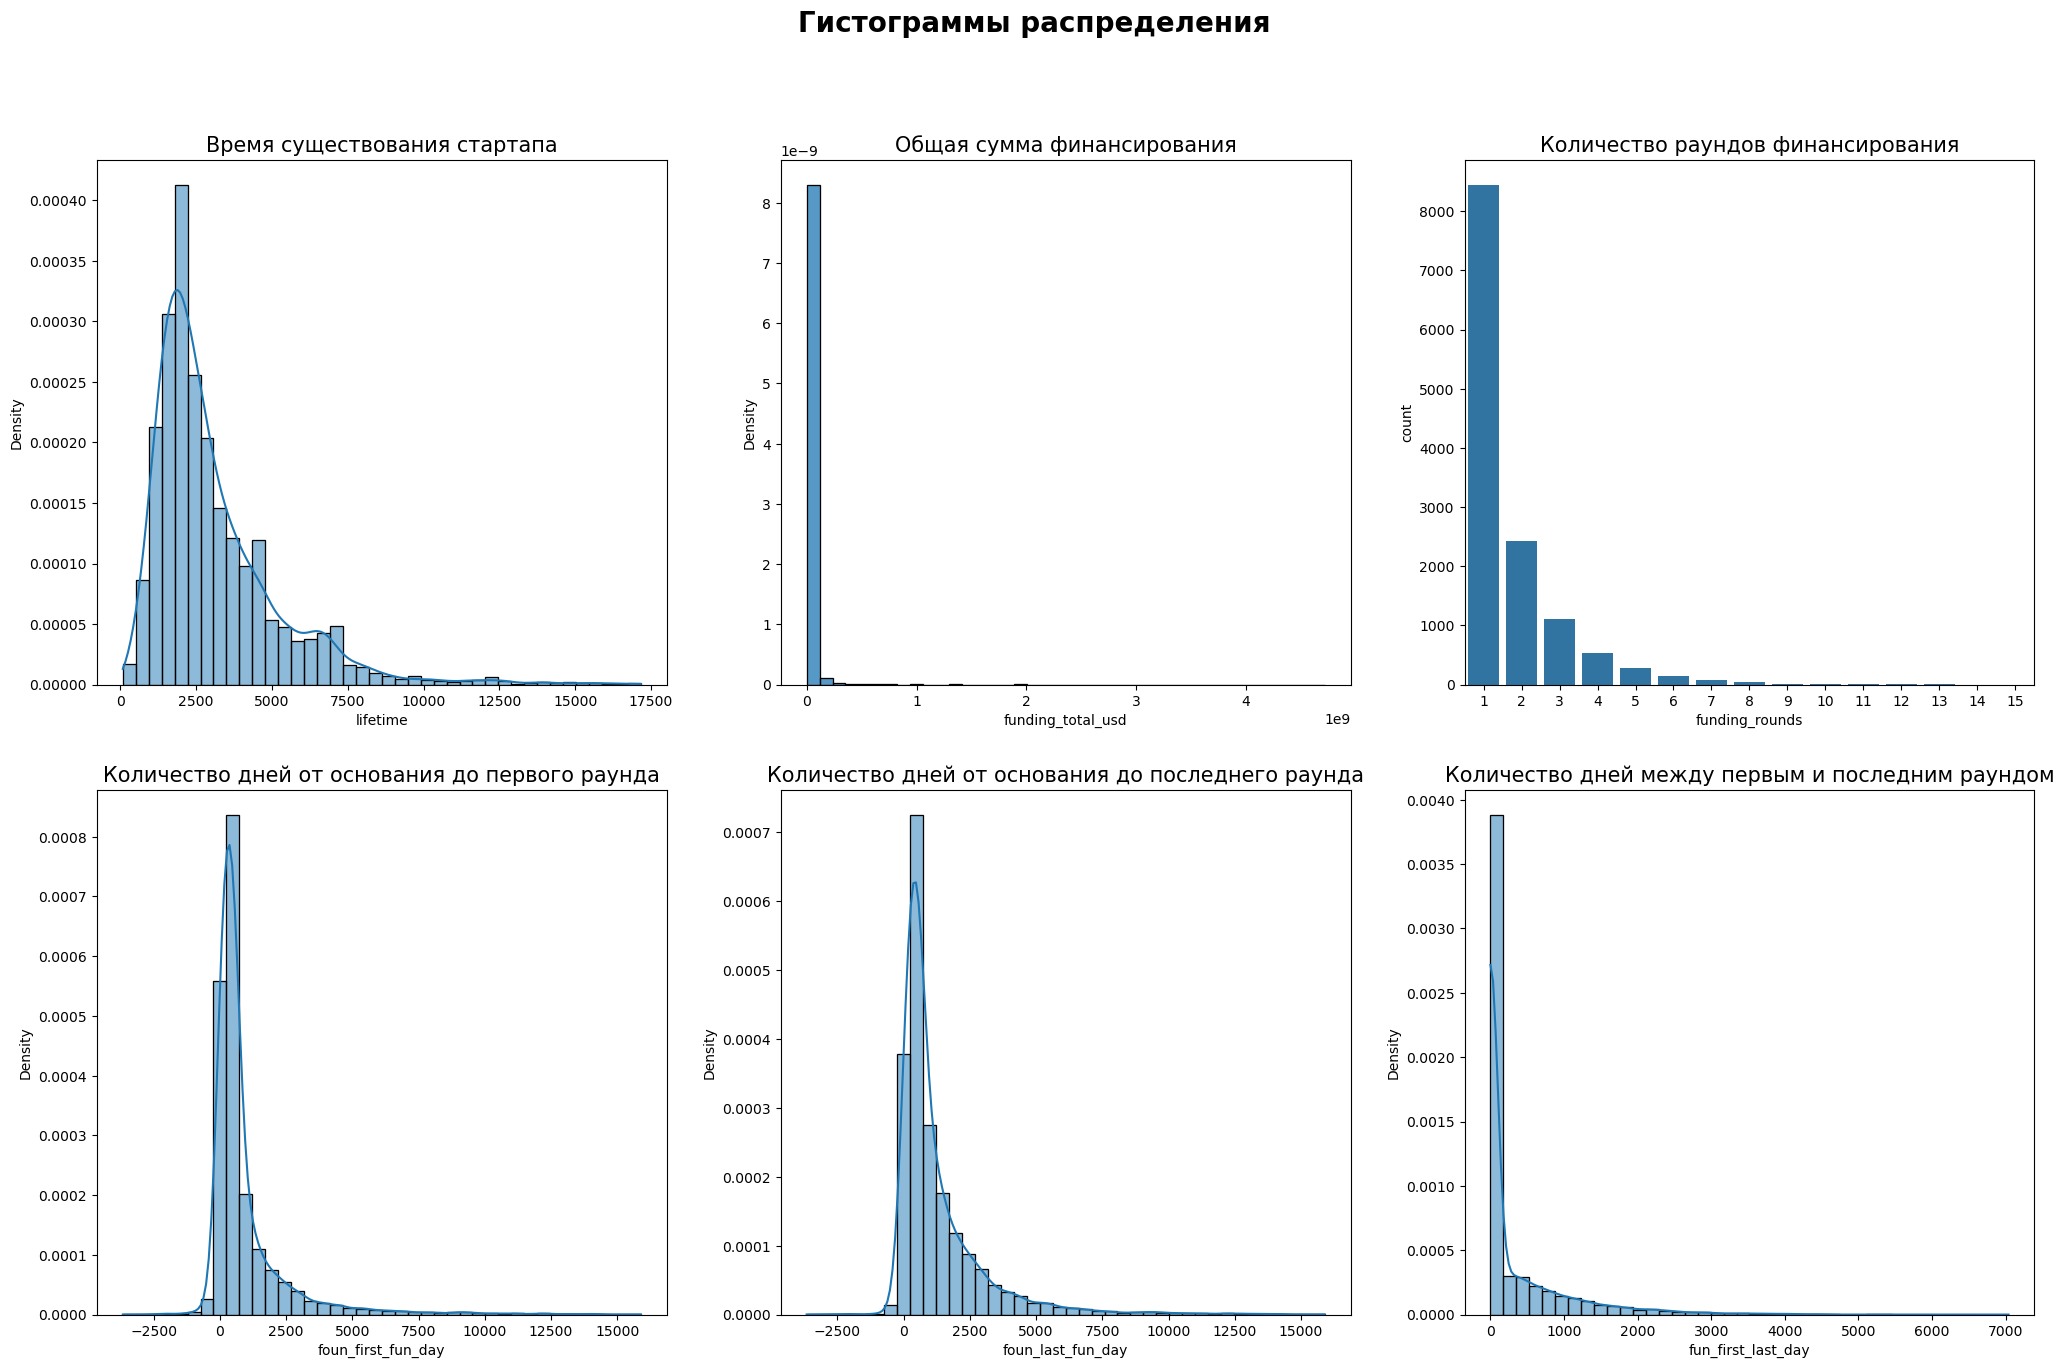

In [117]:
plt.figure(figsize=(25, 15))

plt.suptitle('Гистограммы распределения', fontsize=20, fontweight='bold')

plt.subplot(2, 3, 1)
sns.histplot(data=test_df, x='lifetime', stat='density', common_norm=False, kde=True, bins=40)
plt.title('Время существования стартапа', fontsize=15)

plt.subplot(2, 3, 2)
sns.histplot(data=test_df, x='funding_total_usd', stat='density', common_norm=False, bins=40)
plt.title('Общая сумма финансирования', fontsize=15)

plt.subplot(2, 3, 3)
sns.countplot(data=test_df, x='funding_rounds')
plt.title('Количество раундов финансирования', fontsize=15)

plt.subplot(2, 3, 4)
sns.histplot(data=test_df, x='foun_first_fun_day', kde=True,
            stat='density', common_norm=False, bins=40)
plt.title('Количество дней от основания до первого раунда', fontsize=15)

plt.subplot(2, 3, 5)
sns.histplot(data=test_df, x='foun_last_fun_day', kde=True,
            stat='density', common_norm=False, bins=40)
plt.title('Количество дней от основания до последнего раунда', fontsize=15)

plt.subplot(2, 3, 6)
sns.histplot(data=test_df, x='fun_first_last_day', kde=True,
            stat='density', common_norm=False, bins=40)
plt.title('Количество дней между первым и последним раундом', fontsize=15);

Аналогичная ситуация, как с тренировчным датафреймом. Что-то сказать о выбросах невозможно, так как такие данные не являются выбросами, а в полня могут быть. Можно сказать, что данные имеют ненормальное распредление и чтобы быть уверенным в этом также воспользуемся тестом Шапиро-Уилка.

Воспользуемся функцией `normality_chek`.

Выдвигаем такие же гипотезы о нормальности, что и для тренировочной выборки.:

**H0** - данные распределены нормально

**H1** - данные распределены ненормально.

In [118]:
normality_chek(train_df['lifetime'])

Отвергаем H0. Ненормальное распределение


In [119]:
normality_chek(train_df['funding_total_usd'])

Отвергаем H0. Ненормальное распределение


In [120]:
normality_chek(train_df['funding_rounds'])

Отвергаем H0. Ненормальное распределение


In [121]:
normality_chek(train_df['foun_first_fun_day'])

Отвергаем H0. Ненормальное распределение


In [122]:
normality_chek(train_df['foun_last_fun_day'])

Отвергаем H0. Ненормальное распределение


In [123]:
normality_chek(train_df['fun_first_last_day'])

Отвергаем H0. Ненормальное распределение


Приступим к разделению данных на временные и панельные и создадим панельные данные по статусу и каждому из годов.

Выделим из столбцов с датами только год и вынесим их в отдельные столбцы.

Теперь создадим панельные данные по статусу и каждому из годов

In [124]:
test_pdata_ff = test_df.groupby(['month_first_fun'])['name'].count()

# Сделаем таблицу
test_pdata_ff = pd.DataFrame(test_pdata_ff)

In [125]:
test_pdata_f = test_df.groupby(['month_founded'])['name'].count()

# Сделаем таблицу
test_pdata_f = pd.DataFrame(test_pdata_f)

In [126]:
test_pdata_lf = test_df.groupby(['day_last_fun'])['name'].count()

# Сделаем таблицу
test_pdata_lf = pd.DataFrame(test_pdata_lf)

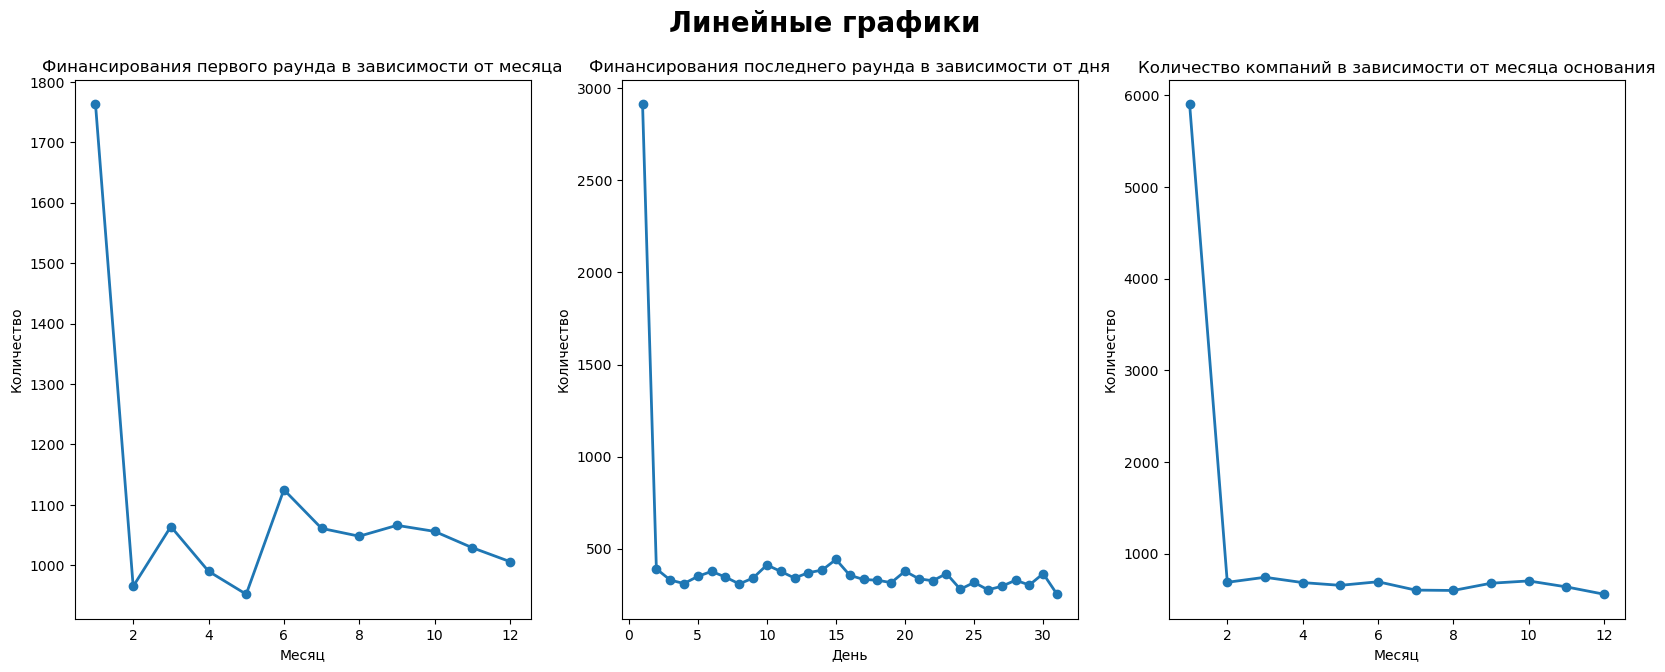

In [127]:
# зададим размер графика
plt.figure(figsize = (20, 7))

plt.suptitle('Линейные графики', fontsize=20, fontweight='bold')

plt.subplot(1, 3, 1)
plt.plot(test_pdata_ff, linewidth = 2, marker = 'o')
plt.xlabel('Месяц')
plt.ylabel('Количество',)
plt.title('Финансирования первого раунда в зависимости от месяца')

plt.subplot(1, 3, 2)
plt.plot(test_pdata_lf, linewidth = 2, marker = 'o')
plt.xlabel('День')
plt.ylabel('Количество',)
plt.title('Финансирования последнего раунда в зависимости от дня')

plt.subplot(1, 3, 3)
plt.plot(test_pdata_f, linewidth = 2, marker = 'o')
plt.xlabel('Месяц')
plt.ylabel('Количество',)
plt.title('Количество компаний в зависимости от месяца основания')

plt.show()

Выводы похожие с тренировочным датафреймом. Чаще открываються стартапы в начале года и чаще финансирование первого раудна происходит также в начале года. В начале месяца обычно происходят последние раунды финансирования.

## Вывод

По результатам исследователького анализа можно сделать следующие выводы:

По тренировочной выборке:

1. По статусу количество стартапов выглядит следующим образом:
    - `closed` - 7.7%
    - `operating` - 92.2%
    
    то есть у нас большая разница между статусами стартапов.
2. По частям света соотношение следующие:
    - `north america` - 66.7%
    - `europa` - 19.4%
    - `asia` - 8.5%
    - `east` - 2%
    - `south america` - 1.9%
    - `australia and oceania` - 1%
    - `africa` - 0.5%
    - `cenral america` - 0.1%
3. Соотношение категорий:
    - `analytic` - 25.9%
    - `entertainment industry` - 19.3%
    - `industrial` - 15%
    - `it` - 14.4%
    - `financy` - 11.6%
    - `health` - 7.7%
    - `transport and travel` - 2.9%
    - `science and education` - 1.6%
    - `socially` - 1.5%
4. Говорить об аномальным значениях мы не можем, так как данные хоть и имееют большой разброс, но это все похоже на реальность, так как сумма финасирования может значительно отличаться от разных компаний, так и количество раундов может быть любым. 
5. Провели тест Шапиро-Уилка и в результате получили, что данные распределенны ненормально
6. При маленькой разнице между датой основания и первым раундом/последним раундом стартапы чаще закрываются, аналогично при разнице между первым и последним раундом.
7. В зависимости от года, можно сказать, что начиная с 2000 годов стали чаще открывать стартапы и эта цифра с каждым годом росла. С увеличением стартапов, они также стали и чаще закрываться. Много стартапов открываются в начале года (первый месяц) из-за этого первые раунди финансирования также больше в начале года. Последние раунды финансирования часто происходят в начале месяца.

По тестовой выборке:

1. По частям света соотношения следующие:
    - `north america` - 66.7%
    - `europa` - 19.4%
    - `asia` - 8.4%
    - `south america` - 2%
    - `east` - 1.9%
    - `australia and oceania` - 1.2%
    - `africa` - 0.4%
    - `cenral america` - 0.1%
2. Соотношение категорий:
    - `analytic` - 26.3%
    - `entertainment industry` - 18.6%
    - `industrial` - 15%
    - `it` - 14.1%
    - `financy` - 12.2%
    - `health` - 7.7%
    - `transport and travel` - 3.1%
    - `science and education` - 1.5%
    - `socially` - 1.5%

Аналогичные выводы, что по аномальным значениям, что и по распределениям. Только в тестовой выборке нет столбца по закрытию стартапа, что и логично, так как необходимо будет предсказать на тестовой закроется или не закроется стартап.

# Корреляционный анализ

Перед тем как приступить к корреляционному анализу, сформируем полный датафрейм, который и будем использовать в обучении. По некоторым признакам выявить взаимосвязь не получиться, то есть уберем следующие столбцы:
- `name`, так как такую-то связь выявить с названиями не получится и вряд-ли от этого зависит закроется или не закроется стартап
- `category_list`, так как по сумме категорий тоже сложно выявить связь и поэтому был создан столбец с основными категориями
- `region` - аналогично сложно выявить взаимосвязь между множеством категорий, вместо него создан `part_world`
- `city` - избыточный столбец 
- столбцы `founded_at`, `first_funding_at`, `last_funding_at` и `closed_at` вместо них будут только новые столбцы с датами, так как в старом виде найти какую-то связь  проблематично.

In [128]:
total_train_df = train_df.drop(columns=['name', 'category_list', 'region', 'city', 
                                        'founded_at', 'first_funding_at', 'last_funding_at', 
                                        'closed_at', 'main_category'], axis=1)

In [129]:
total_test_df = test_df.drop(columns=['name', 'category_list', 'region', 'city', 
                                      'founded_at', 'first_funding_at', 'last_funding_at', 
                                      'main_category'], axis=1)

Исходя из исследовательского анализа стало понятно, что данные в наших датафремах распределены не нормально, поэтому для изучения взаимосвязи между переменнами в таблицах необходимо использовать коэффициент корреляции $\phi_k$, он может находить взаимосвязь между категориальными, порядковыми и интервальными признаками. Чем ближе его значение по модулю к 1, тем сильнее связь.

Расчитаем корреляцию при помощи библиотеки phik для всех наших признаков.

In [130]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_train = (
    total_train_df.phik_matrix(interval_cols=['funding_total_usd', 'lifetime', 'foun_first_fun_day', 
                                              'foun_last_fun_day', 'fun_first_last_day'])
)

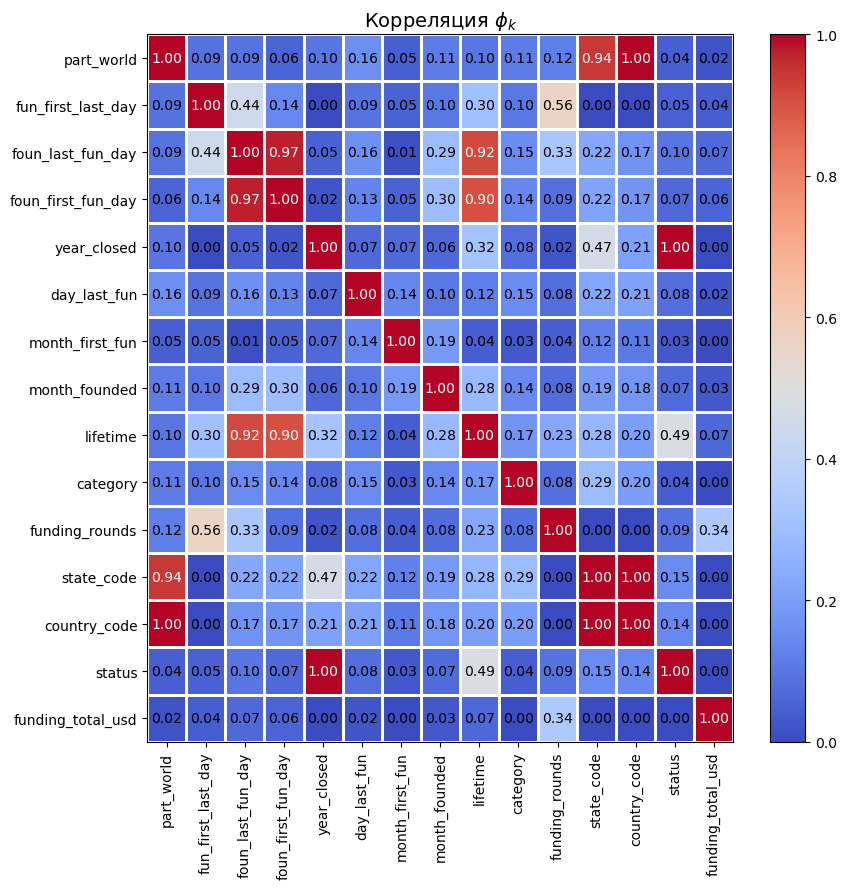

In [131]:
plot_correlation_matrix(phik_matrix_train.values, x_labels=phik_matrix_train.columns, y_labels=phik_matrix_train.index, 
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1, 
                        figsize=(9,9))

plt.tight_layout()

Наш целевой признак `status`, посмотрим как он взаимодействует с входными признаками.

Есть высокая взаимосвязь с `year_closed` - 1 и хорошая с `lifetime` - 0.48. Также есть слабая взаимосвязь с `year_last_fun` - 0.26, `year_first_fun` - 0.20, `year_founded` - 0.15, `state_code` - 0.14, `country_code` - 0.12, `foun_last_fun_day` - 0.12. С признаками `part_world`, `funding_rounds`, `funding_total_usd`, `category`, `fun_first_last_day`, `foun_first_fun_day` сложно судить о взаимосвязи - 0.05, 0.07, 0.00, 0.05, 0.04 и 0.08 соотвествено.

Также можно заметить, что между входными признаками присутсвует сильная взаимосвязь, что говорит о мультиколлинеарности. Мультиколлинеарность есть между следующими признаками:
- `country_code` и `part_world`
- `country_code` и `state_code`
- `state_code` и `part_world`
- `year_closed` и `day_last_fun`
- `foun_first_fun_day` и `foun_last_fun_day`.

В остальных случаях сильной взаимосвязи между входными признаками не наблюдается.

Необходимо избавиться от мультиколлиниеарности. Столбцы `country_code` и `state_code`, как-то изменить не получится, и из столбца `country_code` возник `part_world`, поэтому эти два столбца можно удалить.

Столбец `year_closed` будет удален, так как на нем был основан `lifetime`.

Столбец `fun_last_fun_day` будет удален.

***После обучения, был проведен анализ важности и поэтому удаляются столбцы `month_first_fun` и `day_last_fun`***

***После еще нескольких прогонов были удалены признаки `category` и `funding_total_usd`***

In [132]:
total_train_df = total_train_df.drop(columns=['country_code', 'state_code', 'year_closed', 'foun_last_fun_day',
                                            'month_first_fun','day_last_fun', 'category', 'funding_total_usd'], axis=1)

Еще раз построим корреляционную матрицу.

In [133]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_train = (
    total_train_df.phik_matrix(interval_cols=['funding_total_usd', 'lifetime', 'foun_first_fun_day', 'fun_first_last_day'])
)

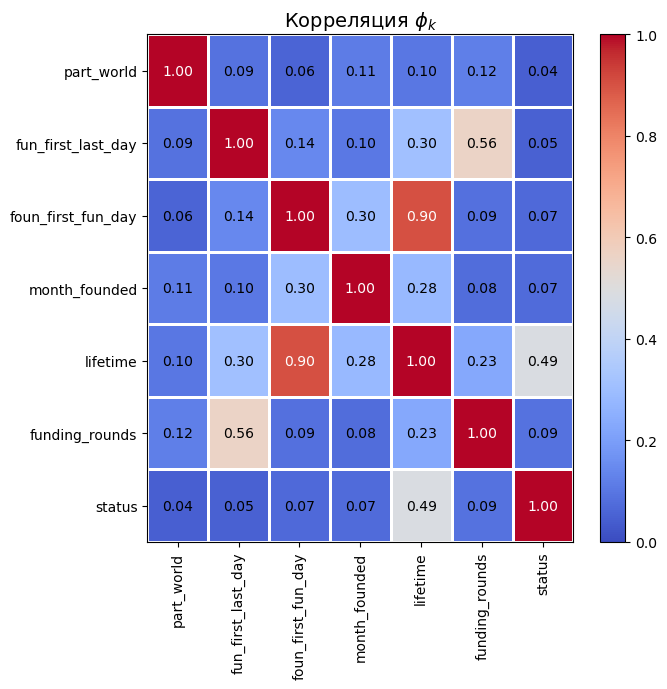

In [134]:
plot_correlation_matrix(phik_matrix_train.values, x_labels=phik_matrix_train.columns, y_labels=phik_matrix_train.index, 
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1, 
                        figsize=(7,7))

plt.tight_layout()

Мультиколлинеарности больше нет. Также осталась хорошая взаимосвязь между `lifetime` и `year_first_fun`\ `foun_first_fun_day`, `status` и `lifetime`, `funding_rounds` и `fun_first_last_day`

Теперь сделаем корреляционный анализ для тестовой выборки.

In [135]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_test = (
    total_test_df.phik_matrix(interval_cols=['funding_total_usd', 'lifetime', 'foun_first_fun_day', 
                                              'foun_last_fun_day', 'fun_first_last_day'])
)

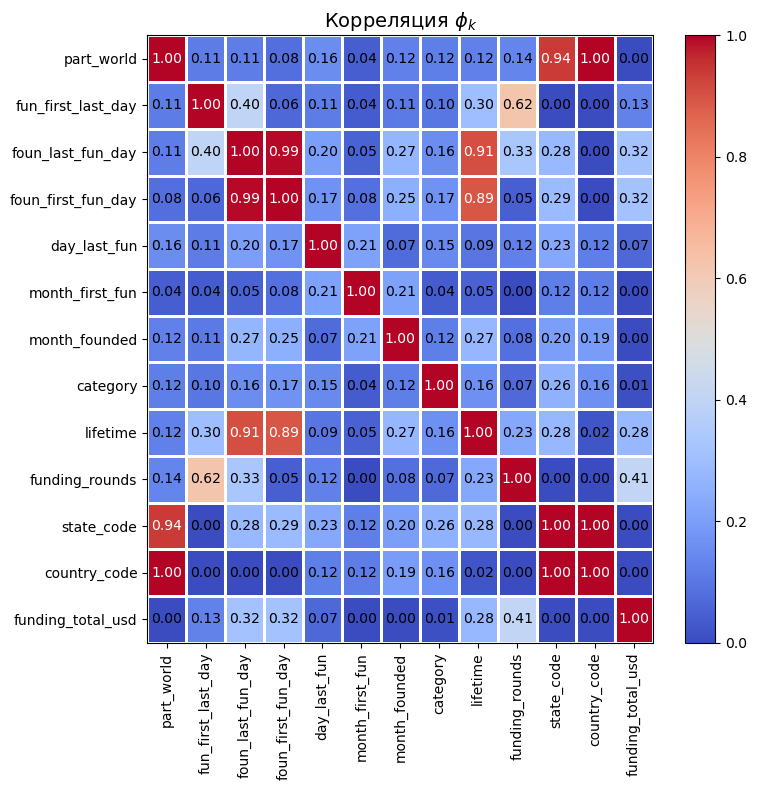

In [136]:
plot_correlation_matrix(phik_matrix_test.values, x_labels=phik_matrix_test.columns, y_labels=phik_matrix_test.index, 
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1, 
                        figsize=(8,8))

plt.tight_layout()

Между признаками есть мультиколлинеарность, а именно между:
- `country_code` и `part_world`
- `country_code` и `state_code`
- `state_code` и `part_world`
- `foun_first_fun_day` и `foun_last_fun_day`.

Удалим такие же столбцы, как и у тренировчной выборки и еще раз построим корреляционную матрицу.

In [137]:
total_test_df = total_test_df.drop(columns=['country_code', 'state_code', 'foun_last_fun_day', 
                                            'month_first_fun','day_last_fun', 'category', 'funding_total_usd'], axis=1)

In [138]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_test = (
    total_test_df.phik_matrix(interval_cols=['funding_total_usd', 'lifetime', 'foun_first_fun_day', 'fun_first_last_day'])
)

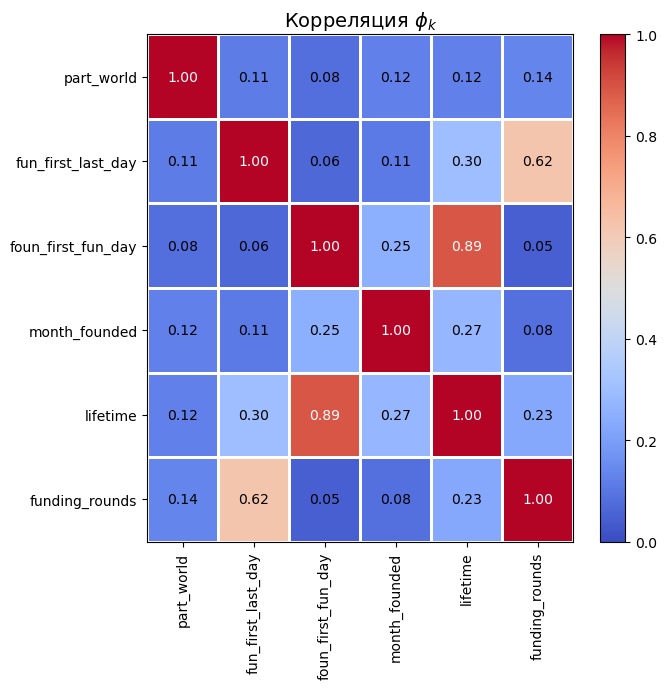

In [139]:
plot_correlation_matrix(phik_matrix_test.values, x_labels=phik_matrix_test.columns, y_labels=phik_matrix_test.index, 
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1, 
                        figsize=(7,7))

plt.tight_layout()

Мультиколлинеарность больше не наблюдается. Есть сильная взаимосвязь между `lifetime` и `year_first_fun`/ `foun_first_fun_day`. Хорошая взаимосвязь между `funding_rounds` и `funding_total_usd`/ `fun_first_last_day`.

# Обучение модели

Приступим к обучению модели. Перед нами стоит задача классификации и нам необходимо предсказть закроется или нет стартап. То есть наш целевой признак `status`. 

Перед обучением данные нужно подготовить. Делать это будем с помощью пайплайнов. Кодировать будем числовые данные спомощью `StandardScaler`, категориальные с помощью `OneHotEncoder`, также закодируем целевой признак, используя `LabelEncoder`.

Будем обучать три модели:
- `LogisticRegression` - логистическую регрессию
- `DecisionTreeClassifier` - деревья решений
- `SVC` - метод опорных векторов с ядром `rbf`

Также для двух первых моделей будем подбирать гиперпараметры при помощи `OptunaSearchSV`, а для метода опорных векторов будем подбирать гиперпараметры при помощи `RandomizedSearchCV`. Оценивать модель будем по метрике `f1`. Также после выбора лучшей модели, проверим ее на адекватность при помощи `DummyClassifier`.

Подготовим тренировчную выборку

In [140]:
X = total_train_df.drop(columns='status', axis=1)
y = total_train_df['status']

In [141]:
# Разделяем данные на тренировочные и валидационные
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

Подготавливаем столбцы для пайплайна

In [142]:
# Создаём списки с названиями признаков
lab_columns = ['status']
ohe_columns = ['part_world']
num_columns = ['lifetime', 'funding_rounds', 'month_founded',
               'foun_first_fun_day',  'fun_first_last_day']

Создаем пайплайн для каждой категории параметров

In [143]:
# Cоздаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

In [144]:
# Cоздаём пайплайн для подготовки признаков из списка num_columns
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent', fill_value=0)),
    ('num', StandardScaler())]
)

In [145]:
# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
    ('num', num_pipe, num_columns)],
    remainder='passthrough'
)

In [146]:
# Кодируем целевой признак
label_encode = LabelEncoder()

y_train_p = label_encode.fit_transform(y_train)
y_valid_p = label_encode.transform(y_valid)

In [147]:
# Пайплайн data_preprocessor применям к тренировочной, валидационной выборкам.
X_train_p = data_preprocessor.fit_transform(X_train)
X_valid_p = data_preprocessor.transform(X_valid)
X_test_p = data_preprocessor.transform(total_test_df)

## Логистическая регрессия

Начне с логистической регресии. Гиперпараметры будем подбирать:

- `C`, который регулирует силу регуляризации.
- `Penalty`, тип регуляризации

In [148]:
# Инициализируем модель логистической регрессии
model_lg = LogisticRegression(random_state=RANDOM_STATE, solver='saga')

In [149]:
# Создаём словарь со значениями гиперпараметров для перебора в optuna
parameters_optlg = {
    'penalty':distributions.CategoricalDistribution(['l1', 'l2']),
    'C':distributions.IntDistribution(1, 5)
}

In [150]:
# Инициализируем OptunaSearchCV
optuna_lg = OptunaSearchCV(
    model_lg,
    parameters_optlg,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

optuna_lg.fit(X_train_p, y_train_p)

y_pred_optlg = optuna_lg.predict(X_valid_p)

print('Лучшая модель и её параметры:\n\n', optuna_lg.best_estimator_)
print(f'Метрика f1 на кросс-валидации: {optuna_lg.best_score_:.2f}')
print(f'Отклонение метрики на кросс-валидации: {pd.DataFrame(optuna_lg.cv_results_)["std_test_score"].mean():.2%}')

[I 2024-06-24 16:54:15,224] A new study created in memory with name: no-name-29f1bcd6-13cf-4dd4-a47f-4fe708da798f
[I 2024-06-24 16:54:18,116] Trial 2 finished with value: 0.9975430986781546 and parameters: {'penalty': 'l2', 'C': 4}. Best is trial 2 with value: 0.9975430986781546.
[I 2024-06-24 16:54:19,680] Trial 1 finished with value: 0.9978772579202413 and parameters: {'penalty': 'l1', 'C': 4}. Best is trial 1 with value: 0.9978772579202413.
[I 2024-06-24 16:54:21,411] Trial 5 finished with value: 0.9978772579202413 and parameters: {'penalty': 'l1', 'C': 4}. Best is trial 1 with value: 0.9978772579202413.
[I 2024-06-24 16:54:21,645] Trial 4 finished with value: 0.9978773272693668 and parameters: {'penalty': 'l1', 'C': 2}. Best is trial 4 with value: 0.9978773272693668.
[I 2024-06-24 16:54:21,691] Trial 6 finished with value: 0.9978772579202413 and parameters: {'penalty': 'l1', 'C': 5}. Best is trial 4 with value: 0.9978773272693668.
[I 2024-06-24 16:54:22,024] Trial 7 finished with v

Лучшая модель и её параметры:

 LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')
Метрика f1 на кросс-валидации: 1.00
Отклонение метрики на кросс-валидации: 0.02%


## Модель дерева решений

Вторая модель будет деревом решений с подбором гиперпараметров:
-  `max_depth` - ограничивает максимальную глубину дерева
-  `min_samples_split` - показывает, сколько объектов должно быть в узле, чтобы они разделились на классы.
-  `min_samples_leaf` -  отвечает за количество объектов в одном листе. 

In [151]:
# Инициализируем модель дерева решений
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Создаём словарь со значениями гиперпараметров для перебора в optuna
parameters_opttree = {
    'min_samples_leaf':distributions.IntDistribution(1, 7),
    'max_depth':distributions.IntDistribution(2, 7),
    'min_samples_split':distributions.IntDistribution(2, 7)
}

# Инициализируем класс для optuna
optuna_tree = OptunaSearchCV(
    model_tree,
    parameters_opttree,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

optuna_tree.fit(X_train_p, y_train_p)

y_valid_tree = optuna_tree.predict(X_valid_p)

print('Лучшая модель и её параметры:\n\n', optuna_tree.best_estimator_)
print(f'Метрика f1 на кросс-валидации: {optuna_tree.best_score_:.2f}')
print(f'Отклонение метрики на кросс-валидации: {pd.DataFrame(optuna_tree.cv_results_)["std_test_score"].mean():.2%}')

[I 2024-06-24 16:54:25,695] A new study created in memory with name: no-name-8c8e8030-6396-4728-a9d4-765ba01e908c
[I 2024-06-24 16:54:25,903] Trial 3 finished with value: 0.9811754130669739 and parameters: {'min_samples_leaf': 4, 'max_depth': 3, 'min_samples_split': 7}. Best is trial 3 with value: 0.9811754130669739.
[I 2024-06-24 16:54:25,972] Trial 1 finished with value: 0.9829085239819758 and parameters: {'min_samples_leaf': 5, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 1 with value: 0.9829085239819758.
[I 2024-06-24 16:54:26,009] Trial 5 finished with value: 0.9846261006157924 and parameters: {'min_samples_leaf': 3, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 5 with value: 0.9846261006157924.
[I 2024-06-24 16:54:26,061] Trial 4 finished with value: 0.9861153111927926 and parameters: {'min_samples_leaf': 3, 'max_depth': 6, 'min_samples_split': 6}. Best is trial 4 with value: 0.9861153111927926.
[I 2024-06-24 16:54:26,073] Trial 2 finished with value: 0.9861708

Лучшая модель и её параметры:

 DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, min_samples_split=5,
                       random_state=42)
Метрика f1 на кросс-валидации: 0.99
Отклонение метрики на кросс-валидации: 0.08%


## Опороные вектора

Третья модели будет обучена с помощью метода опорных веторов с ядром `rbf` и подбором гиперпараметров:
- `C` - параметр регуляризации.
- `gamma` - коэффициент ядра

In [152]:
# Инициализируем модель опроных векторов
model_svc = SVC(kernel='rbf', random_state=RANDOM_STATE)

# Создаём словарь со значениями гиперпараметров для перебора
parameters_svc = {
    'gamma': range(1, 5),
    'C': range(1, 5)
}

randomized_search = RandomizedSearchCV(
    model_svc,
    parameters_svc,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

randomized_search.fit(X_train_p, y_train_p)

y_svc_pred = randomized_search.predict(X_valid_p)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print(f'Метрика f1 на кросс-валидации: {randomized_search.best_score_:.2f}')
print(f'Отклонение метрики на кросс-валидации: {pd.DataFrame(randomized_search.cv_results_)["std_test_score"].mean():.2%}')

Лучшая модель и её параметры:

 SVC(C=3, gamma=1, random_state=42)
Метрика f1 на кросс-валидации: 0.99
Отклонение метрики на кросс-валидации: 0.07%


## Проверка моделей на адекватность

Проверим модель на адекватность, сравнив качество предсказаний с качеством модели, которая предсказывала бы константу.

Для этого воспользуемся `DummyClassifier`. Главное, чтобы ее показания были хуже, чем у обученых нами моделей.

In [153]:
model_dr = DummyClassifier(strategy='most_frequent')
model_dr.fit(X_train_p, y_train_p)

y_pred_dr = model_dr.predict(X_valid_p)

print(f'Метрика f1 на дамми моделе: {f1_score(y_valid_p, y_pred_dr)}')

Метрика f1 на дамми моделе: 0.9592526976968916


Все модели превосходят дамми модель, а значит они прошли проверку на адекватность.

## Результаты на тестовой выборке

Сделаем предсказания на тестовой выборке и сделаем таблицу, в которой будет содержаться только название и статус стартапа. Названия компаний находятся в отдельном файле, в начале необходимо его загрузить.

In [154]:
pth3 = r"C:\Users\stepa\Downloads\kaggle_startups_sample_submit.csv"

In [155]:
if os.path.exists(pth3):
    predict = pd.read_csv(pth3)
else:
    print('Ошибка')

In [156]:
# Предсказания при помощи регрессии
y_test_pred_lg = optuna_lg.predict(X_test_p)

In [157]:
# Предсказания при помощи деревьев
y_test_pred_tree = optuna_tree.predict(X_test_p)

In [158]:
# Предсказания при помощи опорных векторов
y_test_pred_svc = randomized_search.predict(X_test_p)

In [159]:
predict['status'] = label_encode.inverse_transform(y_test_pred_lg)

In [160]:
# Сохраняем предсказания в файл
predict.to_csv('predict.csv', index=False)

## Вывод

Было обучено 3 модели, посмотрим на их результат.

Резульаты модели `DecisionTreeClassifier`:
- f1 на кросс-валдиации: 0.99
- Отклонение метрики на кросс-валидации:, 0.08%

Результаты модели `LogisticClassifier`:
- f1 на кросс-валдиации: 1.00
- Отклонение метрики на кросс-валидации: 0.02%

Результаты модели `SVC`:
- f1 на кросс-валдиации: 0.99
- Отклонение метрики на кросс-валидации:, 0.07%

Исходя из кросс-валидации лучшая модель получается - логистическая, так как отклонение у нее меньше всего. Все модели прошли проверку на адекватность.

Параметры лучшей модели:
- `C` - 2
- `penalty` - l1
- `solver` - saga

# Анализ важности признаков.

Посмотрим на вклад признака в каждый прогноз при помощи значений Шепли

In [161]:
shap_lg = pd.DataFrame(
    X_test_p, columns=data_preprocessor.get_feature_names_out().tolist())

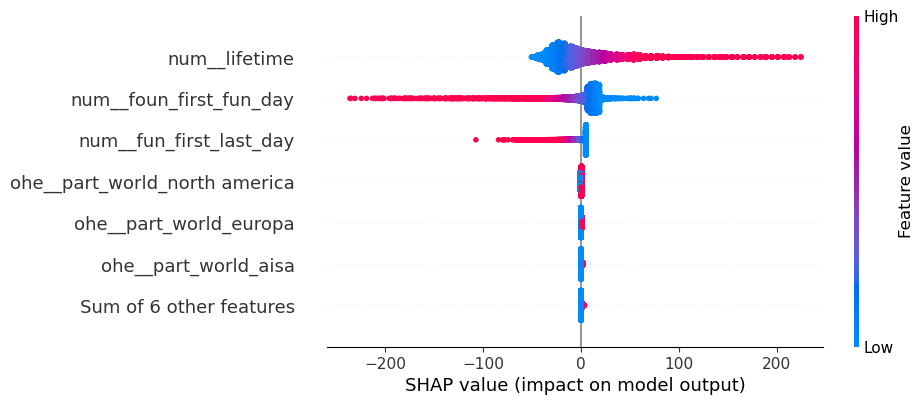

In [162]:
explainer_lg = shap.LinearExplainer(optuna_lg.best_estimator_, X_test_p)
shap_values = explainer_lg(shap_lg)
shap.plots.beeswarm(shap_values, max_display=7)

Интерпритируем результаты:

1. Чем больше значения признака `lifetime` тем выше SHAP значение, то есть если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежать к класу 1, то есть стартап не закроется.
2. Чем больше значение признаков `fun_first_fun_day`, `fun_first_last_day` тем выше вероятность наблюдения принадлежать к классу 0, то есть стартап закроется.

То есть чем больше время существования стартапа, тем больше вероятность, что он не закроется. Также если разница между первым раундом и последним раундом большая, тем больше вероятность закрытия стартапа. Если с момента открытия стартапа, он еще не получил финансирование то тем выше вероятность закрытия стартапа.

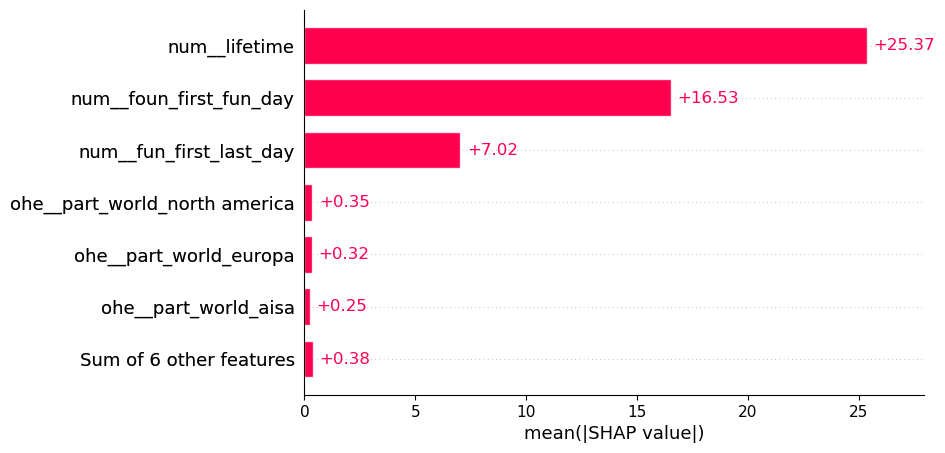

In [163]:
shap.plots.bar(shap_values, max_display=7)

С точки зрения модели наиболее важные признаки, которые влияют на статус стартапа: `lifetime` - время жизни, `fun_first_last_day` - разница в днях между первым и последним раундом финансирования и `foun_first_fun_day` - разница в днях между датой основания и первым раундом финансирования. Между этими признаками существуют взаимосвязи, которые модель смогла выявить.

С точки зрения модели мало значимыми признаками являются `funding_rounds`, `part_world` и `month_founded` - количество раундов финансирования.

# Общий вывод

Данные были получены из следующих файлов:
- `kaggle_startups_test.csv ` - тренировочные данные 
- `kaggle_startups_train.csv` - тестовые данные, на которых необходимо сделать прогноз
- `kaggle_startups_sample_submit.csv`  - примера отчета

Сначала был сделан обзор данных. Само исследование проходило в 7 этапов:

1. Изучить данные;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Корреляционный анализ;
5. Обучение модели;
6. Анализ важности признаков;
7. Общий вывод.

**1. Обзор данных**

В таблице `train_df` - 13 столбцов, тип данных - `int`(1), `object`(11), `float`(1). Количестов значений в столбцах разное, а значит есть пропуски. Название столбцов соотвествует стилю. Исходя из данных в столбце `funding_total_usd` есть странные значение (минимальное значение равное 1)

В таблице  `test_df` - 12 столбцов, тип данных - `int`(1), `object`(9), `float`(2). Количестов значений в столбцах разное, а значит есть пропуски. Название столбцов соотвествует стилю. Исходя из данных в столбце `funding_total_usd` есть странные значение (минимальное значение равное 1)

**2. Предобработка данных**

*В таблице `test_df` строки не удалялись, так как необходимо сделать прогноз по всем стартапам в этом файле*

На данном этапе были сделаны следующие действия:

1. Изменили тип данных столбцов `first_funding_at`, `last_funding_at`, `founded_at` и `closed_at` с `object` на `datetime` во всех датафреймах
2. Сделали проверку на пропуски и избавлись от них следующим способом:
    - В таблице `train_df` в столбец `closed_at` заполнили днем выгрузки данных, так как пропуски образовались из-за того, что стартапы на момент выгрузки не закрылись.  
    - Удалили строчки, которые в сумме не будут нести пользную информацию, а именно те, в которых одноврменно есть пропущенные значения в следующих столбцах: `region`, `city`, `country_code` и `state_code`
    - В таблице `train_df` в столбце `name` был один пропуск, но все остальные столбцы были заполнены, поэтому заполнили название заглужкой `unknown`. *1*
    - В столбце `category_list` некоторые пропуски заполнили основываясь на названиях компаний, то есть некоторые компании могут указывать в названии, чем они занимаются. *2* 
    - В столбцах `city`, `region` и `state_code` заполнили новыми значениями, а имеено название страны `country_code` + ` - other`. *3*
    - Оставшиеся пропуски в `category_list` заполнили модой, а именно `category_list` и затем заменили эту категории на другую категорию в этом столбце `startups`
    - Удалили пропуски в `funding_total_usd` в тренировочной выборке, в тестовой выборке они заполнялись в пайплане.
3. Сделали проверку на явные дубликаты - **не обнаружены.**
4. Сделали проверку на неявные дубликаты, неявные дубликаты, кроме столбца `country_code`, определяли при помощи расстояния Левенштайна и затем исправили их:
    - В столбце `category_list` были найдены дубликаты. Разные окончания у одинаковых слов, ошибки в написанни слов, разное написание одних и тех же категорий и разные разделители в категориях:
        - `sport` и `sports`, `game` и `games`
        - `health` - `mhealth`, `mobile|sns` и `mobile|sms`
        - `e-books` и `ebooks`
        - `health care|information technology|software` и `health care information technology|software`
        - `enterprise software|health care information technology` и `enterprise software|health care|information technology`
        - `health care|information technology|saas|software` и `health care information technology|saas|software`
    - В столбце `region` были найдены дубликаты. Разные написание одних и тех же городов:
        - `melbourne` и `melbourn`
        - `montpellier` и `montpelier`
        - `monterrey` и `monterey`
        - `lyon` и `leon`
    - В столбце `city` также были найдены множество дубликатов.
    - В столбце `state_code` дубликаты не были найдены
    - В столбце `country_code` дубликаты не найдены.
5. Были добавлены новые столбцы:
    - Столбец `lifetime` был добавлен в `train_df`, в котором храниться время существования стартапа в днях. 
    - Столбец `main_category` в датафреймы, который будет содежрать основную деятельность стартапа.
    - Столбец `category`, в который войдут обобщенные категории всех категорий из `category_list`. Все категории был обобщены на 9 категорий: *3*
        - `it`
        - `analytic`
        - `health`
        - `financy`
        - `industrial`
        - `science and education`
        - `transport and travel`
        - `entertainment industry`
        - `socially` 
    - Cтолбец `founded_month`, хранит месяцы основания, 
    - Столбец `month_first_fun` хранит месяцы первого финансирования, 
    - Столбец `day_last_fun` хранит дни последнего финансирования 
    - Столбец `year_closed` хранит год закрытия
    - Столбец `foun_first_fun_day`  разница меду датой основания и первым раундом финансирования, 
    - Столбец `foun_last_fun_day` разница датой основания и последним раундом финансирования
    - Столбец `fun_first_last_day` разница между первым и последним раундом финансирования в днях.
    - Столбец `part_world` в него вошли страны по частям света. Является обобщением столбца `country_code`. Всего будет 8 категорий: *5*
        - `europa`
        - `north america`
        - `asia`
        - `south america`
        - `central america`
        - `east`
        - `australia and oceania`
        - `africa`

6. Пропуски, которые не удалось заполнить в столбце `funding_total_usd` - удалили.

>p.s.
***1**. Заполнили имя заглужкой по двум причинам. 1) Названия компаний не будут использоваться при обучении (слишком много уникальных значений) 2) Необходимо было избавиться от пропуска, что заполнить столбец с категориями*
***2**. Пример из реальных названий: Bethesda **game** studios*
***3**. Сделали так на основе такой же категории в столбце `city`*
***4**. В индустрию развлечений я также отнес рестораны. В транспорт добавил категории связанные с недвижимостью. В категорию `socially` вошло все, что не попадает под остальные, например, спорт, еда, свадьбы, ЖКХ и тп.* 
***5**. Страны карибского моря я отнес к центральной америке, Россия отнесена к Европе, Бермуды отнес к Северной Америке*

**3. Исследовательский анализ данных**

По тренировочной выборке:

1. По статусу количество стартапов выглядит следующим образом:
    - `closed` - 7.7%
    - `operating` - 92.2%
    
    то есть у нас большая разница между статусами стартапов.
2. По частям света соотношение следующие:
    - `north america` - 66.7%
    - `europa` - 19.4%
    - `asia` - 8.5%
    - `east` - 2%
    - `south america` - 1.9%
    - `australia and oceania` - 1%
    - `africa` - 0.5%
    - `cenral america` - 0.1%
3. Соотношение категорий:
    - `analytic` - 25.9%
    - `entertainment industry` - 19.3%
    - `industrial` - 15%
    - `it` - 14.4%
    - `financy` - 11.6%
    - `health` - 7.7%
    - `transport and travel` - 2.9%
    - `science and education` - 1.6%
    - `socially` - 1.5%
4. Говорить об аномальным значениях мы не можем, так как данные хоть и имееют большой разброс, но это все похоже на реальность, так как сумма финасирования может значительно отличаться от разных компаний, так и количество раундов может быть любым. 
5. Для определения нормальности распределений данных. Использовали статистический тест Шапиро-Уилка. Выдвинули две гипотезы о нормальности распределенний. **H0** - данные распределены нормально, **H1** - данные распределены ненормально. В результате все данные имеют ненормальное распределение.
6. При маленькой разнице между датой основания и первым раундом/последним раундом стартапы чаще закрываются, аналогично при разнице между первым и последним раундом.
7. В зависимости от года, можно сказать, что начиная с 2000 годов стали чаще открывать стартапы и эта цифра с каждым годом росла. С увеличением стартапов, они также стали и чаще закрываться. Много стартапов открываются в начале года (первый месяц) из-за этого первые раунди финансирования также больше в начале года. Последние раунды финансирования часто происходят в начале месяца.

По тестовой выборке:

1. По частям света соотношения следующие:
    - `north america` - 66.7%
    - `europa` - 19.4%
    - `asia` - 8.4%
    - `south america` - 2%
    - `east` - 1.9%
    - `australia and oceania` - 1.2%
    - `africa` - 0.4%
    - `cenral america` - 0.1%
2. Соотношение категорий:
    - `analytic` - 26.3%
    - `entertainment industry` - 18.6%
    - `industrial` - 15%
    - `it` - 14.1%
    - `financy` - 12.2%
    - `health` - 7.7%
    - `transport and travel` - 3.1%
    - `science and education` - 1.5%
    - `socially` - 1.5%

Аналогичные выводы, что по аномальным значениям, что и по распределениям. Только в тестовой выборке нет столбца по закрытию стартапа, что и логично, так как необходимо будет предсказать на тестовой закроется или не закроется стартап.

**4. Корреляционный анализ**

Так как наши данные распределены ненормальное, то использовали корреляцию $\phi_k$. Сделали анализ для тренировочной и тестовой выборки.

Результаты на тренировочной выборке.

Наш целевой признак `status`он взаимодействует с входными признаками:

Есть высокая взаимосвязь с `year_closed` - 1 и хорошая с `lifetime` - 0.48. Также есть слабая взаимосвязь с `year_last_fun` - 0.26, `year_first_fun` - 0.20, `year_founded` - 0.15, `state_code` - 0.14, `country_code` - 0.12, `foun_last_fun_day` - 0.12. С признаками `part_world`, `funding_rounds`, `funding_total_usd`, `category`, `fun_first_last_day`, `foun_first_fun_day` сложно судить о взаимосвязи - 0.05, 0.07, 0.00, 0.05, 0.04 и 0.08 соотвествено.

Между входными признаками присутсвует сильная взаимосвязь, что говорит о мультиколлинеарности. Мультиколлинеарность есть между следующими признаками:
- `country_code` и `part_world`
- `country_code` и `state_code`
- `state_code` и `part_world`
- `year_closed` и `day_last_fun`
- `foun_first_fun_day` и `foun_last_fun_day`.

В остальных случаях сильной взаимосвязи между входными признаками не наблюдается.

Необходимо избавиться от мультиколлиниеарности. Столбцы `country_code` и `state_code`, как-то изменить не получится, и из столбца `country_code` возник `part_world`, поэтому эти два столбца можно удалить.

- Столбец `year_closed` будет удален, так как на нем был основан `lifetime`.

- Столбец `fun_last_fun_day` будет удален.

*После обучения, был проведен анализ важности и поэтому удаляются столбцы `month_first_fun` и `day_last_fun`*

Результаты на тестовой выборке.

Признаки взаимосвязаны между собой следующим образом:

- `lifetime` имеет сильную взаимосвязь с `foun_first_fun_day` - 0.89

- `funding_rounds` имеет хорошую взаимосвязь с `fun_first_last_day` - 0.62

- `fun_first_last_day` имеет взаимосвязь с `foun_first_fun_day` - 0.40

- `funding_rounds` имеет взаимосвязь с `funding_total_usd` - 0.41


**5. Обучение модели**

Необходимо было обучить модель. Перед нами стояла задача классификации и нам необходимо предсказть закроется или нет стартап. То есть наш целевой признак `status`. 

Перед обучением данные нужно подготовить. Делать это будем с помощью пайплайнов. Кодировать будем числовые данные спомощью `StandardScaler`, категориальные с помощью `OneHotEncoder`, также закодируем целевой признак, используя `LabelEncoder`.

Будем обучать три модели:
- `LogisticRegression` - логистическую регрессию
- `DecisionTreeClassifier` - деревья решений
- `SVC` - метод опорных векторов с ядром `rbf`

Также для двух первых моделей будем подбирать гиперпараметры при помощи `OptunaSearchSV`, а для метода опорных векторов будем подбирать гиперпараметры при помощи `RandomizedSearchCV`. Оценивать модель будем по метрике `f1`. Также после выбора лучшей модели, проверим ее на адекватность при помощи `DummyClassifier`.

У `DecisionTreeClassifier` подбирали следующие гиперпараметры:

-  `max_depth` - ограничивает максимальную глубину дерева
-  `min_samples_split` - показывает, сколько объектов должно быть в узле, чтобы они разделились на классы.
-  `min_samples_leaf` -  отвечает за количество объектов в одном листе. 

У `LogisticRegression` подбирали следующие гиперпараметры:

- `C`, который регулирует силу регуляризации.
- `Penalty`, тип регуляризации


У `SVC` подбирали следующие гиперпараметры:

- `C` - параметр регуляризации.
- `gamma` - коэффициент ядра


Таблица 1 - Результаты модели
| **Модель** | **f1 на кросс-валидации** | **Отклонение метрики** |**Прошла проверку на адекватность** |
| :---         |     :---:      |     :---:    |     :---:    |
| **LogisticRegression**   | 1.00     | 0.02%    |✅ |
| **DecisionTreeClassifier**     | 0.99       | 0.08%      |✅ |
| **SVC**     | 0.99       | 0.07%      |✅ |


Все модели прошли проверку на адекватность. Лучшая модель получается - логистическая регрессия, так как отклонение у нее меньше всего и метрика лучше всех.

Параметры лучшей модели:
- `C` - 2
- `penalty` - l1
- `solver` - saga

**6. Анализ важности признаков**

Анализ важности признаков делали при помощи значения Шапли и в результате пришли к следующему выводу.

С точки зрения модели наиболее важные признаки, которые влияют на статус стартапа: `lifetime` - время жизни, `fun_first_last_day` - разница в днях между первым и последним раундом финансирования и `foun_first_fun_day` - разница в днях между датой основания и первым раундом финансирования. Между этими признаками существуют взаимосвязи, которые модель смогла выявить.

С точки зрения модели мало значимыми признаками являются `funding_rounds`, `part_world` и `month_founded` - количество раундов финансирования.

1. Чем больше значения признака `lifetime` тем выше SHAP значение, то есть если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежать к класу 1, то есть стартап не закроется.
2. Чем больше значение признаков `fun_first_fun_day`, `fun_first_last_day` тем выше вероятность наблюдения принадлежать к классу 0, то есть стартап закроется.

То есть чем больше время существования стартапа, тем больше вероятность, что он не закроется. Также если разница между первым раундом и последним раундом большая, тем больше вероятность закрытия стартапа. Если с момента открытия стартапа, он еще не получил финансирование то тем выше вероятность закрытия стартапа.

**Вывод**

По результатам исследования была обучена модель, которая может предсказывать закроется или не закроется стартап, то есть его статус.

Статус зависит очень сильно от время существования стартапа, чем он больше существует, тем больше шансов не закрыться. Можно обратить внимание на разницу в днях между первым и последним раундом финансирования, чем она больше, тем велик шанс на закрытие стартапа.

Также неменее важным является первое финансирование, чем раньше оно происходит тем лучше (даже до открытия стартапа). Если же после открытия стартапа проходит много времени до первого финансирования, тем больше вероятность, что стартап закроется.